# EuBIC Winterschool 2024 Valkenborg lab Workshop

During todays session we will be exploring several tools developed in the Valkenborg lab from UHasselt, Belgium. These tools are mostly focused on the MS1 layer of mass spectrometry-based proteomics. For each tool, we will be giving a short introductory presentation of 15 minutes to give a general idea about the corresponding tools. Each presentation is followed by a 30 minute workshop to acquire some hands-on experience. The syntax used is R. The following tools will be discussed:



*   BRAIN: BRAIN, or Baffling Recursive Algorithm for Isotopic distributioN is an algorithm to accurately calculate the aggregated isotope distribution from an elemental composition using a polynomial method.
*   Pointless4Peptides: Pointless4Peptides is a novel algorithm to predict the isotope distribution of average peptides based on their monoisotopic mass. Employing penalized spline regression to model the isotope distribution as a function of the monoisotopic mass. The combination of a compositional data representation with penalized spline regression offers a precise and flexible
method to model the isotope probabilities. Additionally, acknowledging the importance of Sulphur in the isotope distribution, the model allows for highly accurate detection of Sulphur present in the molecule.
*   MIND: MIND or MonoIsotopic liNear preDictor is a framework to accurately predict the monoistopic mass of a precursor peptide, utilizing the most abundant isotope peak.
*   QCQuan: QCQuan is an online web application that automatically provides the user with an exploratory and quality control analysis and a differential expression analysis of a quantitative label-based proteomics experiment.




## Packages

We start out by loading several packages used throughout the workshops. As they aren't the main focus of this workshop, we will only shortly elaborate their functionality.


*   Tidyverse: Tidyverse is a collection of packages with the core message: "Making data science easier". It contains packages to facilitate importing data types, data wrangling, visualisations and exporting data.  
*   Phylotools: Phylotools is a collection of tools to work with FASTA files for example. We primarily will use it to read the FASTA files.



In [ ]:
# Installation of packages
install.packages(c("phylotools", "viridis","caret", "kableExtra"))

# Loading packages
library(tidyverse)
library(phylotools)
library(viridis)
library(knitr)
library(kableExtra)
library(caret)
# Our seed for sampling
set.seed(2024)

# Warning messages
knitr::opts_chunk$set(echo = TRUE, warning = FALSE, message = FALSE)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘Rcpp’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘ape’, ‘gridExtra’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’, ‘webshot’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ape


Att

# BRAIN

## Workshop

First of all, BRAIN was compiled as an R-package, easily installable. An in-depth documentation can be found on:

https://www.bioconductor.org/packages/release/bioc/manuals/BRAIN/man/BRAIN.pdf

As a short reiteration:
BRAIN uses an algebraic approach to calculate the aggregated isotope distribution and masses for each aggregated isotopic variant for chemical components built from carbon, hydrogen, oxygen, nitrogen and sulfur such as peptides.

BRAIN can easily be installed through the command below. Depending on your computer, this may take several minutes.


In [ ]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("BRAIN")

library(BRAIN)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.2 (2023-10-31)

Installing package(s) 'BiocVersion', 'BRAIN'

also installing the dependencies ‘bitops’, ‘zlibbioc’, ‘RCurl’, ‘GenomeInfoDbData’, ‘BiocGenerics’, ‘S4Vectors’, ‘IRanges’, ‘XVector’, ‘GenomeInfoDb’, ‘PolynomF’, ‘Biostrings’


Old packages: 'pbdZMQ', 'bit', 'curl', 'DBI', 'devtools', 'digest', 'gargle',
  'glue', 'highr', 'isoband', 'openssl', 'ragg', 'readr', 'reprex', 'rlang',
  'roxygen2', 'textshaping', 'uuid', 'whisker', 'boot', 'MASS', 'Matrix',
  'nlme'

Loading required package: PolynomF


Attaching package: ‘PolynomF’


The following object is masked from ‘package:purrr’:

    zap


Loading required package: Biostrings

Loading required pa

We will shortly iterate over several of the key-functionalities of the package during the workshop and demonstrate it on a theoretical dataset.

As a theoretical dataset, we start out by performing an in-silico digestion of the entire UNIPROT database of canonical human reviewed proteins using trypsin [1]. The human proteome contains 20.428 proteins (01/12/2023).
All sequences are available in a FASTA-format on the GitHub page and can be loaded using the code chunk below. In order to save computational time, we will randomly sample 1.000 proteins using the seed "2024". We exclude peptides containing selenocysteine.


---

**UNIPROT reference:**

Bateman, A., Martin, M., Orchard, S., Magrane, M., Ahmad, S., Alpi, E., Bowler-Barnett, E., Britto, R., Bye-A-Jee, H., Cukura, A., Denny, P., Doğan, T., Ebenezer, T. E., Fan, J., Garmiri, P., Gonzales, L., Hatton-Ellis, E., Hussein, A., Ignatchenko, A., . . . Sundaram, S. (2022). UniProt: The Universal Protein Knowledgebase in 2023. Nucleic Acids Research, 51(D1), D523–D531. https://doi.org/10.1093/nar/gkac1052

In [ ]:
Human_proteome <- phylotools::read.fasta("https://raw.githubusercontent.com/VilenneFrederique/EuBIC2024WS/main/uniprotkb_Human_AND_model_organism_9606_2023_12_01.fasta")
Human_proteome <- Human_proteome$seq.text
# Find indices of elements containing the letter 'U'
indices_to_remove <- grep("U", Human_proteome)

# Remove elements containing 'U'
Human_proteome <- Human_proteome[-indices_to_remove]
length(Human_proteome)

[1] 20403

In [ ]:
Human_proteome_sampled <- sample(Human_proteome, size = 1000, replace = FALSE)
length(Human_proteome_sampled)

[1] 1000

The first step in analysing our theoretical dataset is doing a tryptic digest on the human proteome data.
Trypsin is a protease, meaning it cleaves proteins at specific points in the amino-acid sequence. Trypsin cleaves after Lysine and Arginine, except when followed by proline, commonly denoted as [RK].\<P>. Within the setting of MS-based proteomics, trypsin is the most commonly used protease due to several reasons:



*   Trypsin is highly efficient and specific in its cleavage, which makes the peptide fragments highly reproducible.
*   The peptides generated by trypsin are highly suitable for mass spectrometry. The peptides have a good distribution of sizes, enhancing identification of mass spectra.
*   Most database search engines are biased towards the identification of tryptic peptides.
*   It is the golden standard of the proteomics community.

The function below performs a tryptic digest on a peptide sequence.

In [ ]:
# Function to perform tryptic digest on a single peptide sequence
tryptic_digest <- function(peptide) {
  # Use gsub to replace K or R with a space if they are not followed by P
  cleaved_peptides <- gsub("(K|R)(?!P)", "\\1 ", peptide, perl = TRUE)

  # Split the modified peptide into fragments
  fragments <- unlist(strsplit(cleaved_peptides, " "))

  # Remove empty strings from the fragments
  fragments <- fragments[nchar(fragments) > 0]

  return(fragments)
}

In [ ]:
# Apply tryptic_digest function to each peptide in the vector
Human_peptides <- lapply(Human_proteome_sampled, tryptic_digest)

# Flatten the list of lists into a single vector
Human_peptides <- unlist(Human_peptides)

# Number of peptides
length(Human_peptides)

[1] 60782

The tryptic digest on the 1.000 human proteins results into approximately 61.000 tryptic peptides. And this is assuming our trypsin never missed a cleavage site. Keep in mind that within a regular MS-experiment, we typically allow up to 2 missed cleavages! Hence, there could practically be way more peptides!

However, this contains duplicate peptides. We will only work with unique peptides to avoid redundancy.

In [ ]:
Human_peptides_unique <- unique(Human_peptides)
length(Human_peptides_unique)

[1] 39454

As observed, out of ~61.000 peptides, only ~40.000 were unique peptides. This means that approximately 36% were duplicates and redundant.

Now we have our theoretical dataset ready, we will start out with exploring several key functionalities of BRAIN. To start off, while we will be working within a dataframe setting, BRAIN requires lists and vectors, hence information is extracted from the dataframe and added back to it in each for loop. As for the BRAIN related functions:


*   getAtomsFromSeq: The function computing an atomic composition from (naturally occuring) amino acid sequence. It only allows for the 20 naturally occuring amino acids.
*   calculateMonoisotopicMass: The function calculates the monoisotopic mass given an amino acid sequence.
*   calculateAverageMass: The function calculates the average mass given an amino acid sequence.
*   useBrain: The function computes the probabilities of isotopic variants and their aggregated masses for chemical components composed of carbon, hydrogen, oxygen, nitrogen and sulfur (e.g. peptides). Additionally the function returns also the monoisotopic mass and the average mass of given chemical
component.

The entire code should take less than 5 minutes for almost 40.000 peptides.


In [ ]:
Human_peptides_DF <- data.frame("Peptides" = Human_peptides_unique)

Human_peptides_DF["AAComp"] <- NA
Human_peptides_DF["Monoisotopic Mass"] <- NA
Human_peptides_DF["Average Mass"] <- NA
Human_peptides_DF["Carbons"] <- NA
Human_peptides_DF["Hydrogens"] <- NA
Human_peptides_DF["Oxygens"] <- NA
Human_peptides_DF["Nitrogens"] <- NA
Human_peptides_DF["Sulphurs"] <- NA
Human_peptides_DF["BRAINMassPeak1"] <- NA
Human_peptides_DF["BRAINMassPeak2"] <- NA
Human_peptides_DF["BRAINMassPeak3"] <- NA
Human_peptides_DF["BRAINMassPeak4"] <- NA
Human_peptides_DF["BRAINMassPeak5"] <- NA
Human_peptides_DF["BRAINMassPeak6"] <- NA
Human_peptides_DF["BRAINIsotopePeak1Probability"] <- NA
Human_peptides_DF["BRAINIsotopePeak2Probability"] <- NA
Human_peptides_DF["BRAINIsotopePeak3Probability"] <- NA
Human_peptides_DF["BRAINIsotopePeak4Probability"] <- NA
Human_peptides_DF["BRAINIsotopePeak5Probability"] <- NA
Human_peptides_DF["BRAINIsotopePeak6Probability"] <- NA

for(index in 1:nrow(Human_peptides_DF)){
  # Extract information from dataframe required
  Peptide <- Human_peptides_DF[[index, "Peptides"]]
  # Firstly, we calculate the atomic composition of a peptide sequence and store the results into our dataframe
  AAComp <- getAtomsFromSeq(Peptide)
  Human_peptides_DF[index, "Carbons"] <- AAComp[["C"]]
  Human_peptides_DF[index, "Hydrogens"] <- AAComp[["H"]]
  Human_peptides_DF[index, "Oxygens"] <- AAComp[["O"]]
  Human_peptides_DF[index, "Nitrogens"] <- AAComp[["N"]]
  Human_peptides_DF[index, "Sulphurs"] <- AAComp[["S"]]
  Human_peptides_DF[index, "AAComp"] <- paste0("C", AAComp[["C"]], "H", AAComp[["H"]], "O", AAComp[["O"]], "N", AAComp[["N"]], "S", AAComp[["S"]])
  # Using the amino composition, we can calculate the monoisotopic and average mass
  Human_peptides_DF[index, "Monoisotopic Mass"] <- calculateMonoisotopicMass(AAComp)
  Human_peptides_DF[index, "Average Mass"] <- calculateAverageMass(AAComp)
  # Lastly, we will calculate the probabilities of aggregated isotopic variants
  BRAINResults <- useBRAIN(aC = AAComp, stopOption="nrPeaks", nrPeaks = 6)
  Human_peptides_DF[index, "BRAINMassPeak1"] <- BRAINResults[["masses"]][1]
  Human_peptides_DF[index, "BRAINMassPeak2"] <- BRAINResults[["masses"]][2]
  Human_peptides_DF[index, "BRAINMassPeak3"] <- BRAINResults[["masses"]][3]
  Human_peptides_DF[index, "BRAINMassPeak4"] <- BRAINResults[["masses"]][4]
  Human_peptides_DF[index, "BRAINMassPeak5"] <- BRAINResults[["masses"]][5]
  Human_peptides_DF[index, "BRAINMassPeak6"] <- BRAINResults[["masses"]][6]
  Human_peptides_DF[index, "BRAINIsotopePeak1Probability"] <- BRAINResults[["isoDistr"]][1]
  Human_peptides_DF[index, "BRAINIsotopePeak2Probability"] <- BRAINResults[["isoDistr"]][2]
  Human_peptides_DF[index, "BRAINIsotopePeak3Probability"] <- BRAINResults[["isoDistr"]][3]
  Human_peptides_DF[index, "BRAINIsotopePeak4Probability"] <- BRAINResults[["isoDistr"]][4]
  Human_peptides_DF[index, "BRAINIsotopePeak5Probability"] <- BRAINResults[["isoDistr"]][5]
  Human_peptides_DF[index, "BRAINIsotopePeak6Probability"] <- BRAINResults[["isoDistr"]][6]
}

Now that BRAIN has completed all calculations, it is time to explore the corresponding results. As a starter, we will visualise the distribution of monoisotopic masses.

As you can observe, most masses are centered between 0 and 2500 Daltons, so even while working with unique peptides, our masses are still highly similar or even identical.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 52 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


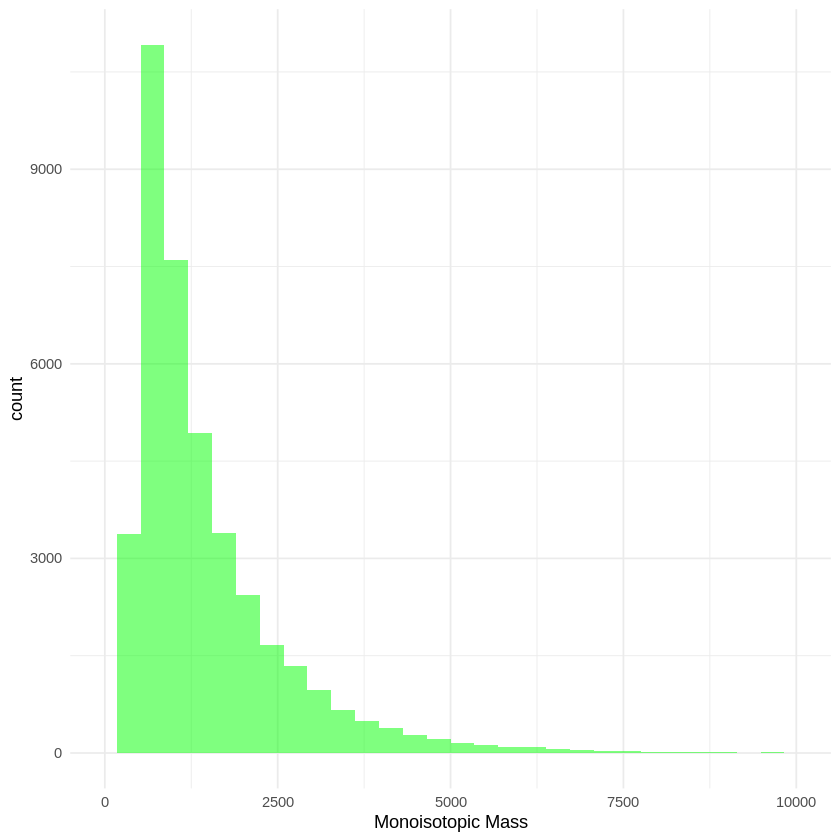

In [ ]:
Human_peptides_DF %>%
  ggplot(aes(x = `Monoisotopic Mass`)) +
  geom_histogram(fill = "green", alpha = 0.5) +
  xlim(0, 10000) +
  theme_minimal()

And to make things even more complicated, a mass spectrometer has small measurement errors. When we zoom in on a specific regions within this mass range,you will notice that the monoisotopic mass is not unique to a peptide.

In the graph below, we zoomed in on the mass range of 2000 to 2010 Daltons, with bin sizes of 0.5 Dalton. As you may notice, multiple peptides occur at these specific masses. Now imagine, a mass spectrometer having a measurement error of 0.5 Dalton. Imagine how complicated things may get to identify peptides based on solely their mass to charge!

Luckily, we can accurately rely on tandem mass spectrometry to identify fragmentation spectra. However, what would research be if we did not try to unravel all the mechanics behind mass spectrometry-based proteomics.

Let's delve a bit further into the specificity of the mass. Why is the mass not unique for a peptide? If you recall, we selected unique peptides... Why is the mass not unique then?

Warning message:
“Removed 39358 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


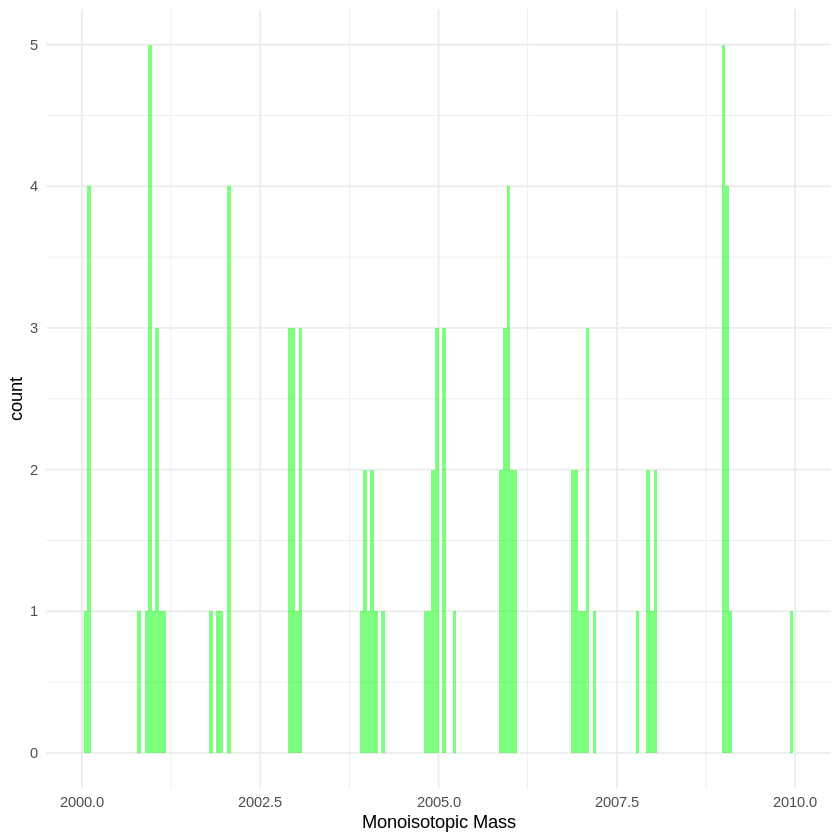

In [ ]:
Human_peptides_DF %>%
  ggplot(aes(x = `Monoisotopic Mass`)) +
  geom_histogram(bins = 200, alpha = 0.5, fill = "green") +
  xlim(2000, 2010) +
  theme_minimal()

One of the reasons here is that even though we are working with unique peptide sequences, their atomic compositions are not! While we have approximately 40.000 peptide sequences, the amount of unique atomic compositions is significantly lower.

In [ ]:
Atomic_Comp <- Human_peptides_DF$AAComp
length(Atomic_Comp)

[1] 39454

As you can see below, approximately 25% of all the atomic compositions were replicates with identical atomic compositions, and hence, also duplicate atomic masses.


In [ ]:
Atomic_Comp_Unique <- unique(Atomic_Comp)
length(Atomic_Comp_Unique)

[1] 29375

Now we know that the atomic composition is not unique. But what about the mass?

Given that we have about 40.000 Peptides, around 25% of the monoisotopic masses are also not unique.

In [ ]:
MonoIsotopicMass <- Human_peptides_DF$`Monoisotopic Mass`
length(MonoIsotopicMass)
MonoIsotopicMass_Unique <- unique(MonoIsotopicMass)
length(MonoIsotopicMass_Unique)

[1] 39454

[1] 29375

BRAIN calculated the monoisotopic mass with 4 digits. But let's imagine we start rounding those masses to 3 or even 2 digits, something which is commonly done.

As you can observe in the code chunk below, this will decrease the specificity of the masses even more!

In [ ]:
MonoIsotopicMass_3Digits <- round(MonoIsotopicMass, digits = 3)
MonoIsotopicMass_3Digits_Unique <- unique(MonoIsotopicMass_3Digits)
length(MonoIsotopicMass_3Digits_Unique)

MonoIsotopicMass_2Digits <- round(MonoIsotopicMass, digits = 2)
MonoIsotopicMass_2Digits_Unique <- unique(MonoIsotopicMass_2Digits)
length(MonoIsotopicMass_2Digits_Unique)

[1] 29152

[1] 24322

Now, let's get into the key feature of BRAIN. BRAIN is able to compute the aggregated isotope distribution using the useBRAIN function. We computed this distribution for each peptide in our dataset. These isotope distributions can be used for a variety of useful goals, one of which we will discuss later on in Pointless4Peptides.

We will show several isotope distributions, starting out with a simple peptide:

"ARPPAAPGR"

*   A monoisotopic mass of 891.5039 Daltons
*   Carbons: 38
*   Hydrogens: 65
*   Oxygens: 10
*   Nitrogens: 15
*   Sulphurs: 0

 As you can observe, the monoisotopic peak is the most abundant peak. This is usually the case, however, we will investigate another peptide.

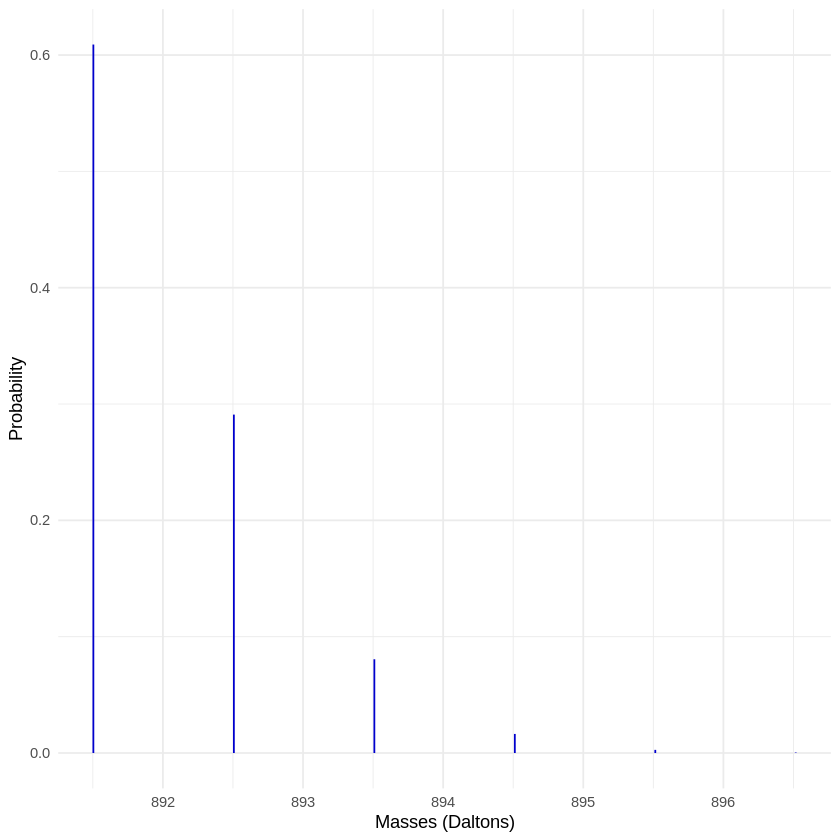

In [ ]:
Human_peptides_DF %>%
  filter(Peptides == "ARPPAAPGR") %>%
  select(10:21) -> ARPPAAPGR

ARPPAAPGR_masses <- as.vector(as.matrix(ARPPAAPGR[1,1:6]))
ARPPAAPGR_intensities <- as.vector(as.matrix(ARPPAAPGR[1,7:12]))
ARPPAAPGR_DF <- data.frame(Masses = ARPPAAPGR_masses, Intensities = ARPPAAPGR_intensities)
ARPPAAPGR_DF %>%
  ggplot(aes(x = Masses, y = Intensities)) +
  geom_segment(aes(x=Masses, xend=Masses, y=0, yend=Intensities), colour = "mediumblue") +
  theme_minimal() +
  xlab("Masses (Daltons)") +
  ylab("Probability")

Next, we will investigate the peptide "LQALAPYSVTSPQPCEMQR"

*   A monoisotopic mass of 2118.0238 Daltons
*   Carbons: 91
*   Hydrogens: 147
*   Oxygens: 29
*   Nitrogens: 25
*   Sulphurs: 2

This peptide is twice the mass of the previous peptide, and as you can observe, now the monoisotopic peak suddenly no longer has the most abundant peak. As the number of atoms in a peptide increases, the larger the probability of occurence for a different isotopic variant of that atom. For most atoms, the probability of a different isotopic variant is relatively low \(<1%\). There is one exception to this rule, namely Sulphur. Sulphur has almost a 5% probability of occuring with 2 additional protons. We will investigate the influence of sulphur a bit more!

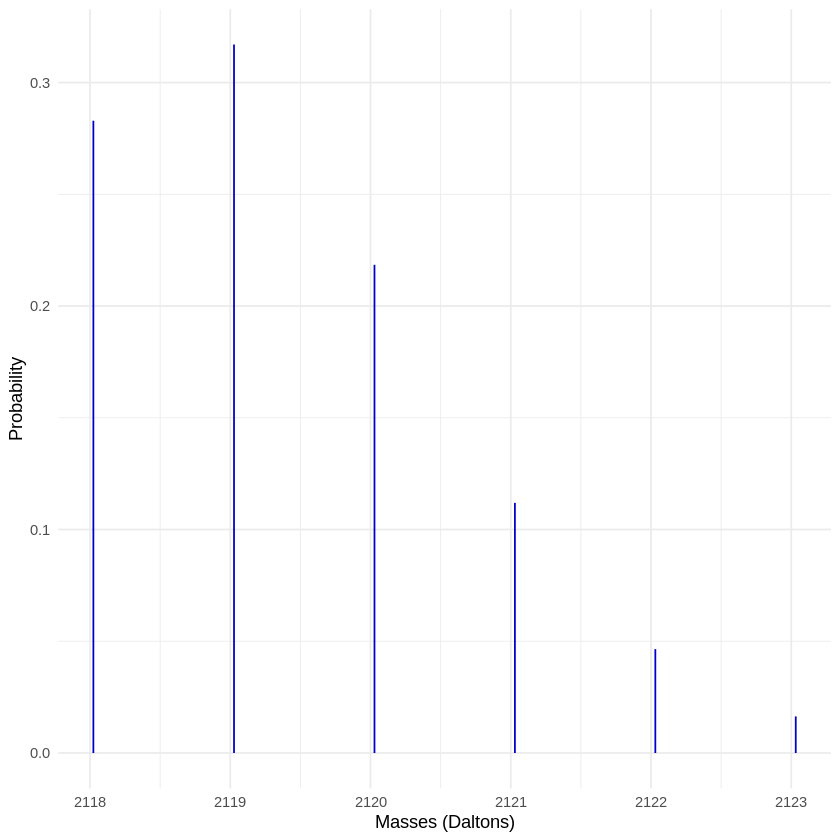

In [ ]:
Human_peptides_DF %>%
  filter(Peptides == "LQALAPYSVTSPQPCEMQR") %>%
  select(10:21) -> LQALAPYSVTSPQPCEMQR

LQALAPYSVTSPQPCEMQR_masses <- as.vector(as.matrix(LQALAPYSVTSPQPCEMQR[1,1:6]))
LQALAPYSVTSPQPCEMQR_intensities <- as.vector(as.matrix(LQALAPYSVTSPQPCEMQR[1,7:12]))
LQALAPYSVTSPQPCEMQR_DF <- data.frame(Masses = LQALAPYSVTSPQPCEMQR_masses, Intensities = LQALAPYSVTSPQPCEMQR_intensities)
LQALAPYSVTSPQPCEMQR_DF %>%
  ggplot(aes(x = Masses, y = Intensities)) +
  geom_segment(aes(x=Masses, xend=Masses, y=0, yend=Intensities), colour = "mediumblue") +
  theme_minimal() +
  xlab("Masses (Daltons)") +
  ylab("Probability")

Next, we will investigate the peptide "ALHPAAVSAAAEFENAESEADFSIHFNR"

*   A monoisotopic mass of 3000.4000 Daltons
*   Carbons: 132
*   Hydrogens: 193
*   Oxygens: 44
*   Nitrogens: 37
*   Sulphurs: 0

This peptide is has a mass of 3000 Daltons without containing any sulphurs. A similar pattern is observed here, where the monoisotopic peak is no longer the most abundant one. It is most likely that one of the atoms within our peptide will occur as a different isotope, even at such low probabilities.

Let's take a look at a final example!

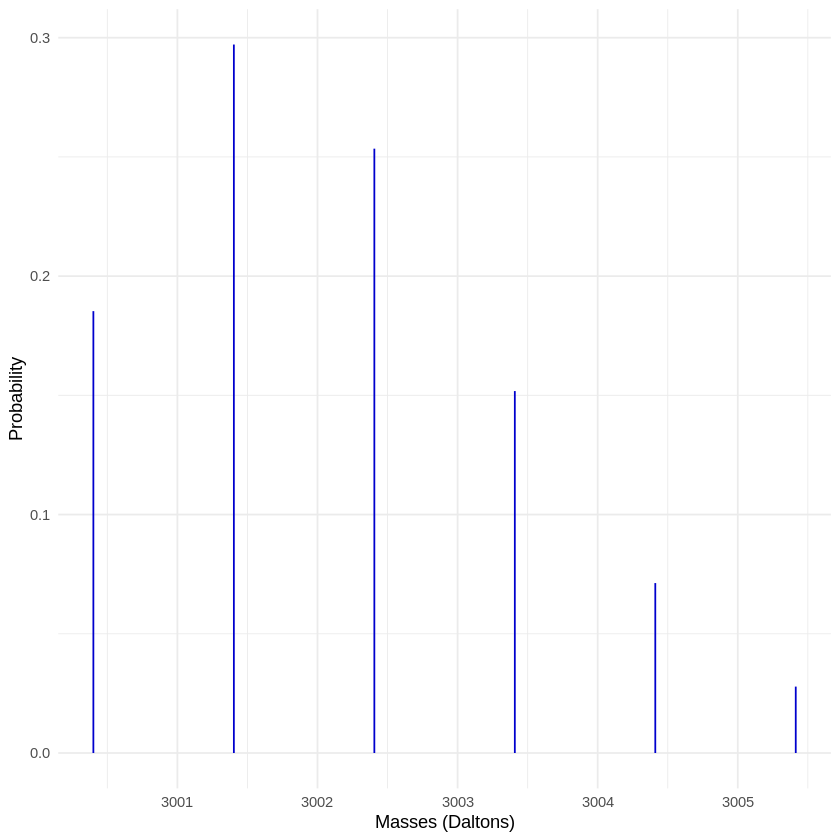

In [ ]:
Human_peptides_DF %>%
  filter(Peptides == "ALHPAAVSAAAEFENAESEADFSIHFNR") %>%
  select(10:21) -> ALHPAAVSAAAEFENAESEADFSIHFNR

ALHPAAVSAAAEFENAESEADFSIHFNR_masses <- as.vector(as.matrix(ALHPAAVSAAAEFENAESEADFSIHFNR[1,1:6]))
ALHPAAVSAAAEFENAESEADFSIHFNR_intensities <- as.vector(as.matrix(ALHPAAVSAAAEFENAESEADFSIHFNR[1,7:12]))
ALHPAAVSAAAEFENAESEADFSIHFNR_DF <- data.frame(Masses = ALHPAAVSAAAEFENAESEADFSIHFNR_masses, Intensities = ALHPAAVSAAAEFENAESEADFSIHFNR_intensities)
ALHPAAVSAAAEFENAESEADFSIHFNR_DF %>%
  ggplot(aes(x = Masses, y = Intensities)) +
  geom_segment(aes(x=Masses, xend=Masses, y=0, yend=Intensities), colour = "mediumblue") +
  theme_minimal() +
  xlab("Masses (Daltons)") +
  ylab("Probability")

Next, we will investigate the peptide "CVACCR"

*   A monoisotopic mass of 653.2448 Daltons
*   Carbons: 23
*   Hydrogens: 43
*   Oxygens: 7
*   Nitrogens: 9
*   Sulphurs: 3

The peptide is relatively light compared to our previous examples, yet it contains 3 sulphurs. Even though sulphur has a larger probability of ocurring in a different isotope, the monoisotopic peak is still the largest in this case.

For us as a research group, this created one key question. Can we distinguish the amount of sulphur atoms based on the mass?

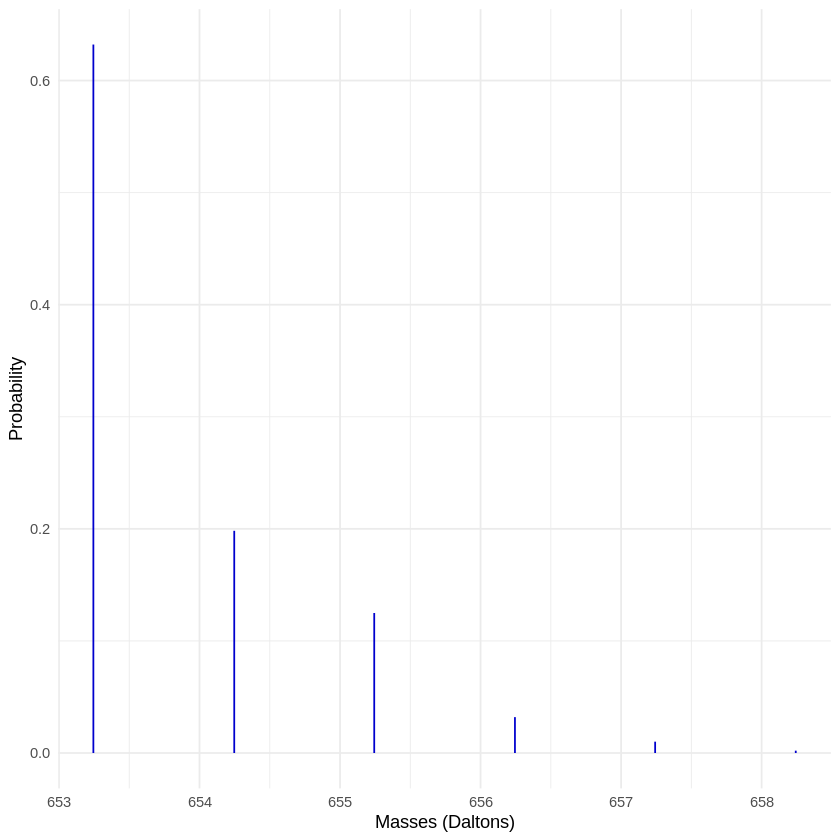

In [ ]:
Human_peptides_DF %>%
  filter(Peptides == "CVACCR") %>%
  select(10:21) -> CVACCR

CVACCR_masses <- as.vector(as.matrix(CVACCR[1,1:6]))
CVACCR_intensities <- as.vector(as.matrix(CVACCR[1,7:12]))
CVACCR_DF <- data.frame(Masses = CVACCR_masses, Intensities = CVACCR_intensities)
CVACCR_DF %>%
  ggplot(aes(x = Masses, y = Intensities)) +
  geom_segment(aes(x=Masses, xend=Masses, y=0, yend=Intensities), colour = "mediumblue") +
  theme_minimal() +
  xlab("Masses (Daltons)") +
  ylab("Probability")

As you can observe, the amount of sulphurs increases as the monoisotopic mass increases. This is logical, as peptides tend to be heavier, it will also contain more amino acids and likely, an amino acid containing sulphur.


Warning message:
“Removed 40 rows containing non-finite values (`stat_density()`).”


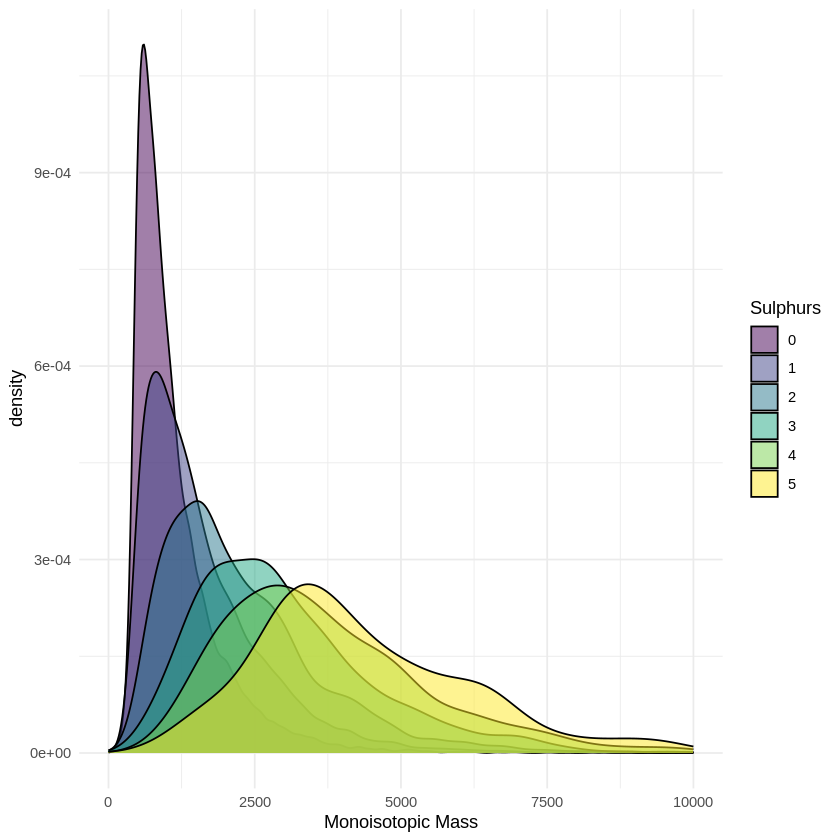

In [ ]:
Human_peptides_DF %>%
  filter(Sulphurs <= 5) %>%
  ggplot(aes(x = `Monoisotopic Mass`, fill = as.factor(Sulphurs))) +
  geom_density(alpha = 0.5) +
  xlim(0, 10000) +
  scale_fill_viridis(discrete = TRUE) +
  labs(fill = "Sulphurs") +
  theme_minimal()

Lastly, below we will look a little bit more in-depth into the relative intensity of the isotope peak 1 to 6 computed through BRAIN in function of the monoisotopic mass, coloured for the number of sulphur atoms. We limited ourselves within the range of 0 to 5000 Daltons and 5 or less sulphurs.

As you may observe, the relative intensity allows for a discrimination between a different number of atoms.


Warning message:
“Removed 4032 rows containing missing values (`geom_point()`).”


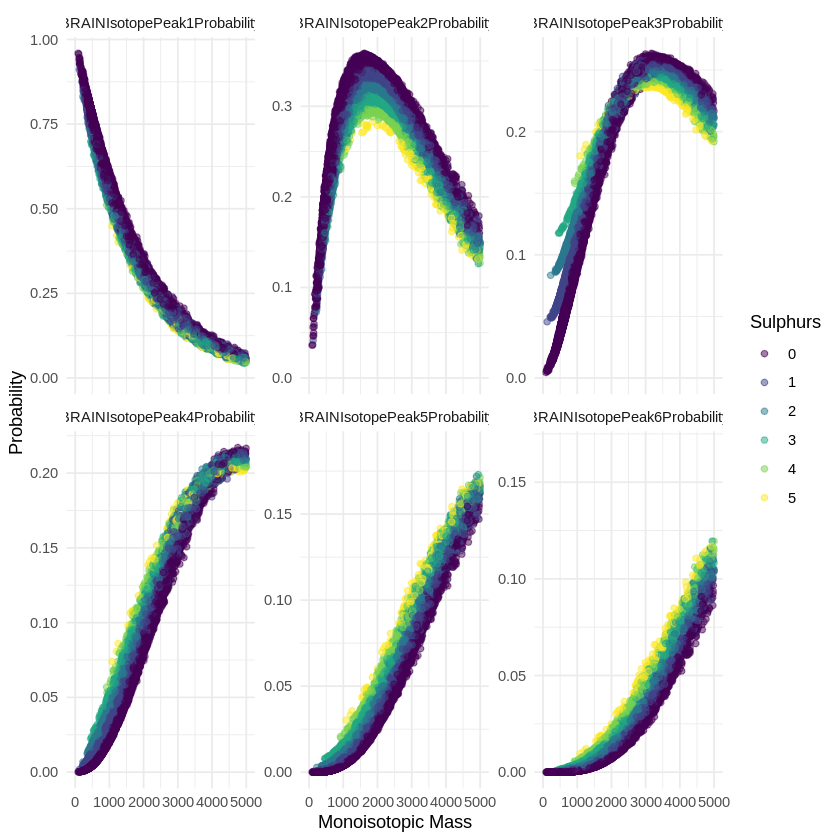

In [ ]:
Human_peptides_DF %>%
  filter(Sulphurs <= 5) %>%
  select(`Monoisotopic Mass`, Sulphurs, BRAINIsotopePeak1Probability:BRAINIsotopePeak6Probability) %>%
  gather(key = "Peak", value = "Probability", BRAINIsotopePeak1Probability:BRAINIsotopePeak6Probability) %>%
  ggplot(aes(x = `Monoisotopic Mass`, y = Probability, colour = as.factor(Sulphurs))) +
  geom_point(alpha = 0.5) +
  facet_wrap(.~Peak, scales = "free_y") +
  theme_minimal() +
  xlim(0, 5000) +
  scale_colour_viridis(discrete = TRUE) +
  labs(colour = "Sulphurs")

And for 0 Sulphurs specifically. You may notice that the probability of having 0 sulphurs follows specific patterns, which begs us the question:

**Can we use the isotope distribution to predict the number of sulphur atoms?**


Warning message:
“Removed 732 rows containing missing values (`geom_point()`).”


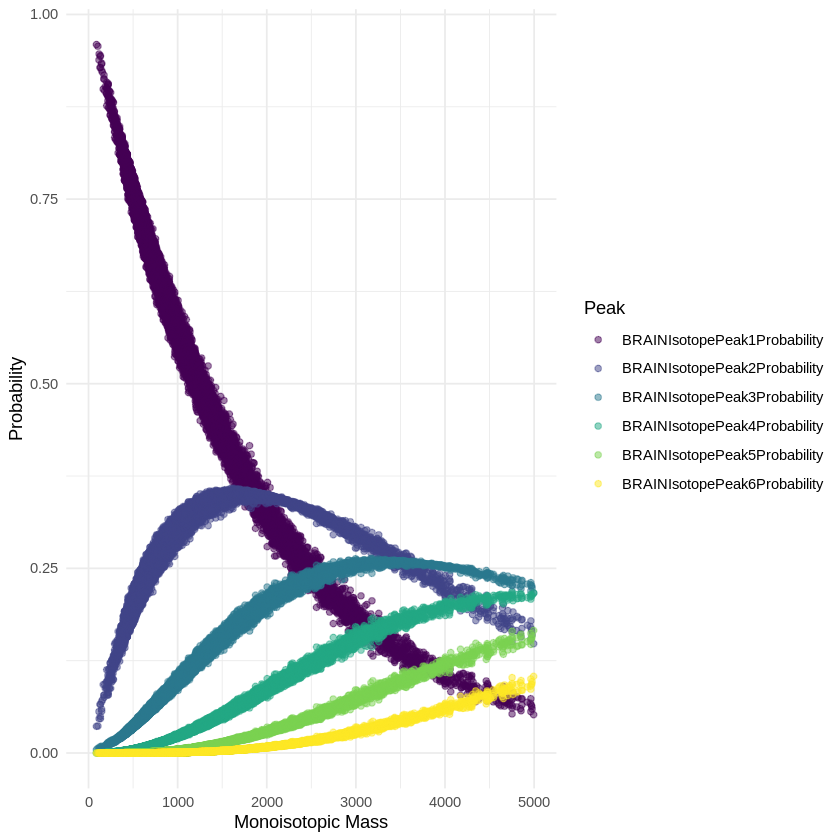

In [ ]:
Human_peptides_DF %>%
  filter(Sulphurs == 0) %>%
  select(`Monoisotopic Mass`, Sulphurs, BRAINIsotopePeak1Probability:BRAINIsotopePeak6Probability) %>%
  gather(key = "Peak", value = "Probability", BRAINIsotopePeak1Probability:BRAINIsotopePeak6Probability) %>%
  ggplot(aes(x = `Monoisotopic Mass`, y = Probability, colour = Peak)) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  xlim(0, 5000) +
  scale_colour_viridis(discrete = TRUE) +
  labs(colour = "Peak")

# Pointless4Peptides

## Workshop

To get started, we use the 1000 sampled human peptides from which the monoisotopic masses are already calculated using the BRAIN algorithm. One caveat is that the model is only reliable up from 350 to 5000 Da. However, if we filter the full dataset of sampled human peptides, this only removes 763 peptides, or less than 2% of the complete dataset.

Pointless4Peptides uses a combination of six models to predict the theoretical isotope distribution of peptides up until six peaks. Why does the algorithm use six models? Because the amount of sulphur in a peptide matters a lot when assessing the distribution.

For this workshop, we will use already prepared datasets as the amount of data necessary is too much to download and calculate the isotope distributions for all selected human peptides. First, we will load the dataset where the Pointless4Peptides model predicted isotope peaks for all human peptides. Each dataset contains the isotope masses and six peak predictions. As the name suggests, the "Sulphurs_In_Predictions" column shows the amount of sulphurs that is put into the model.

The model function is available at:

https://dsi-uhasselt.shinyapps.io/pointless4peptides/

In [ ]:
# Load in all sulphur predictions
Human_peptides_Pointless_AllPredictions = read_csv("https://media.githubusercontent.com/media/VilenneFrederique/EuBIC2024WS/main/Pointless_Predictions.csv")

Rows: 232062 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Peptides, AAComp
dbl (32): Monoisotopic Mass, Average Mass, Carbons, Hydrogens, Oxygens, Nitr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


We have two probability distributions at our disposal:
- The distribution from BRAIN, calculated using the elemental distribution of each peptide.
- The distribution from Pointless4Peptides, calculated only by giving the monoisotopic mass and the amount of sulphurs in the peptide.

We can calculate a Chi-Squared error based on the differences in probability between these two distributions.

The Chi-Squared error is defined as follows:

$$
\frac{(Observed Peak - Expected Peak)^2}{Expected Peak}
$$

In [ ]:
# Calculate the chi squared error between the 6 BRAIN peaks and the 6 POINTLESS peaks
BRAIN_vector_dataframe = Human_peptides_Pointless_AllPredictions[,16:21]
Pointless_vector_dataframe = Human_peptides_Pointless_AllPredictions[,29:34]

temp_df = ((Pointless_vector_dataframe - BRAIN_vector_dataframe)^2)/BRAIN_vector_dataframe
ChiSq_Error = rowSums(temp_df)
Human_peptides_Pointless_AllPredictions["ChiSquared_Error"] = ChiSq_Error

We can compare both distributions using the Pearson chi-squared error and plot this error as a a scatter plot across their monoisotopic mass. This will give us an idea of the capabilities of the model.

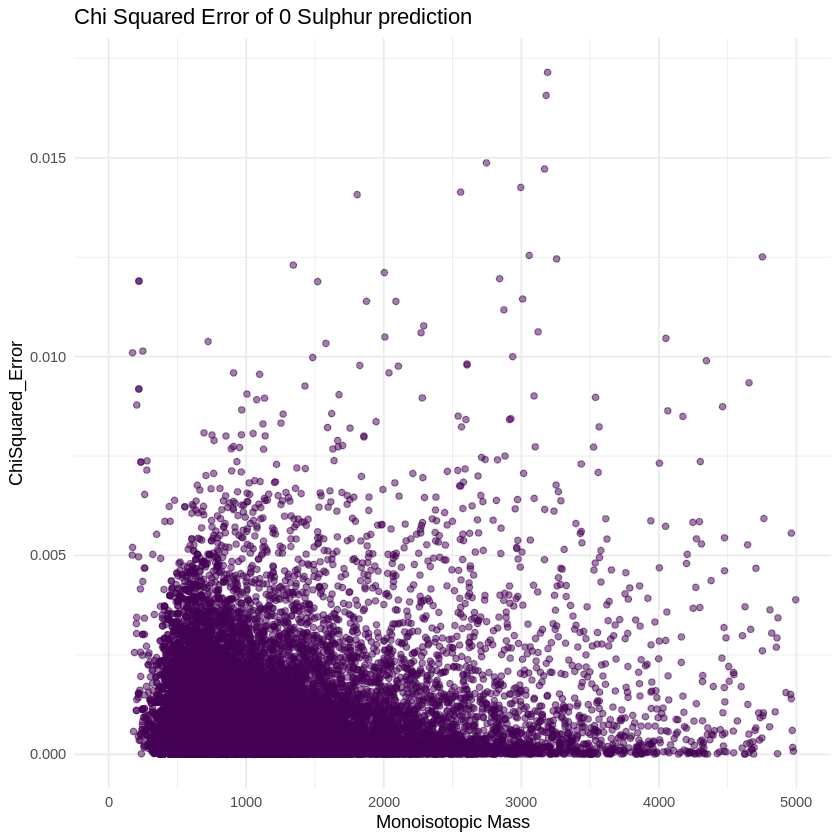

In [ ]:
# Scatter plot for the chi squared error between 0 Sulphur peptides and 0 Sulphur predictions
Human_peptides_Pointless_AllPredictions %>%
  filter(Sulphurs == 0 & Sulphurs_In_Prediction == 0) %>%
  select(`Monoisotopic Mass`, ChiSquared_Error) %>%
  ggplot(aes(x = `Monoisotopic Mass`, y = ChiSquared_Error, colour = "purple")) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  xlim(0, 5000)+
  ggtitle("Chi Squared Error of 0 Sulphur prediction")+
  scale_colour_viridis(discrete = TRUE) +
  theme(legend.position="none")

The errors shown are quite small, with most of them being in between the 0 and 0,01 range. The larger errors on the left are the peak predictions of singular amino acids.

Now, what happens when we don't pick the correct model prediction, i.e. we select the wrong amount of sulphurs? For example, we can predict the 6 isotope distibrution for all peptides with 0 sulphur while using the 3 sulphur model and check the resulting errors.

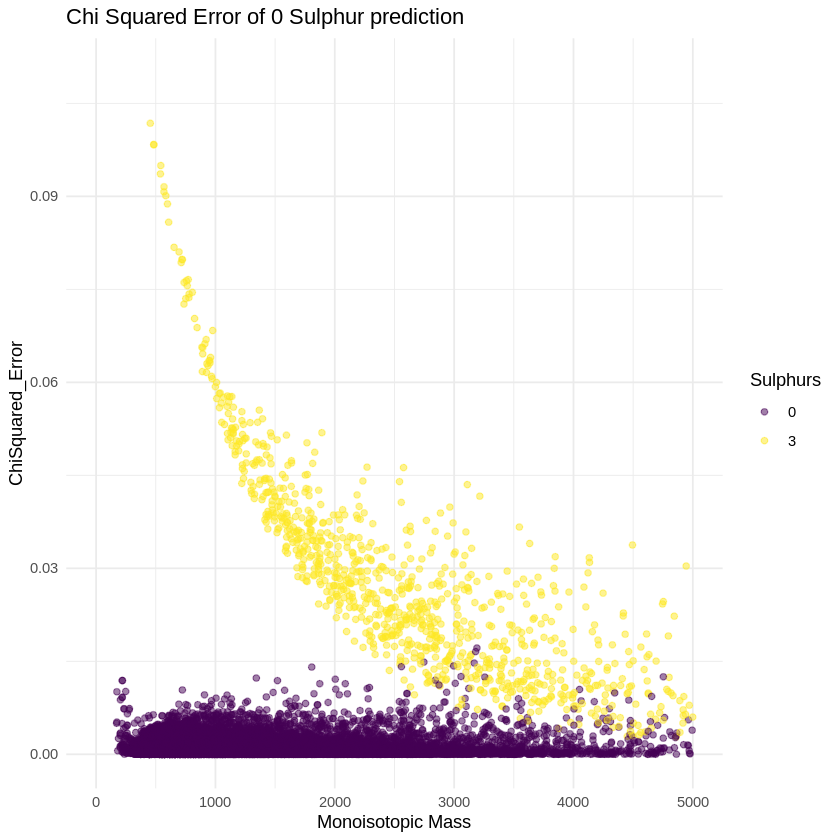

In [ ]:
# Scatter plot for the chi squared error between 0 Sulphur peptides and 3 Sulphur predictions
Human_peptides_Pointless_AllPredictions %>%
  filter((Sulphurs == 0 | Sulphurs == 3) & Sulphurs_In_Prediction == 0) %>%
  select(`Monoisotopic Mass`, Sulphurs, ChiSquared_Error) %>%
  ggplot(aes(x = `Monoisotopic Mass`, y = ChiSquared_Error, colour = as.factor(Sulphurs))) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  xlim(0, 5000) +
  ylim(0, 0.110) +
  scale_colour_viridis(discrete = TRUE) +
  labs(colour = "Sulphurs") +
  ggtitle("Chi Squared Error of 0 Sulphur prediction")

The difference between the models is very clear! Therefore, we can see that it is important to select the correct model when predicting the isotope distributions. There is also a clear reduction in error noticeable when increasing the monoisotopic mass.

Let's perform the correct predictions with the 3 sulphur peptides using the 3 sulphur model.

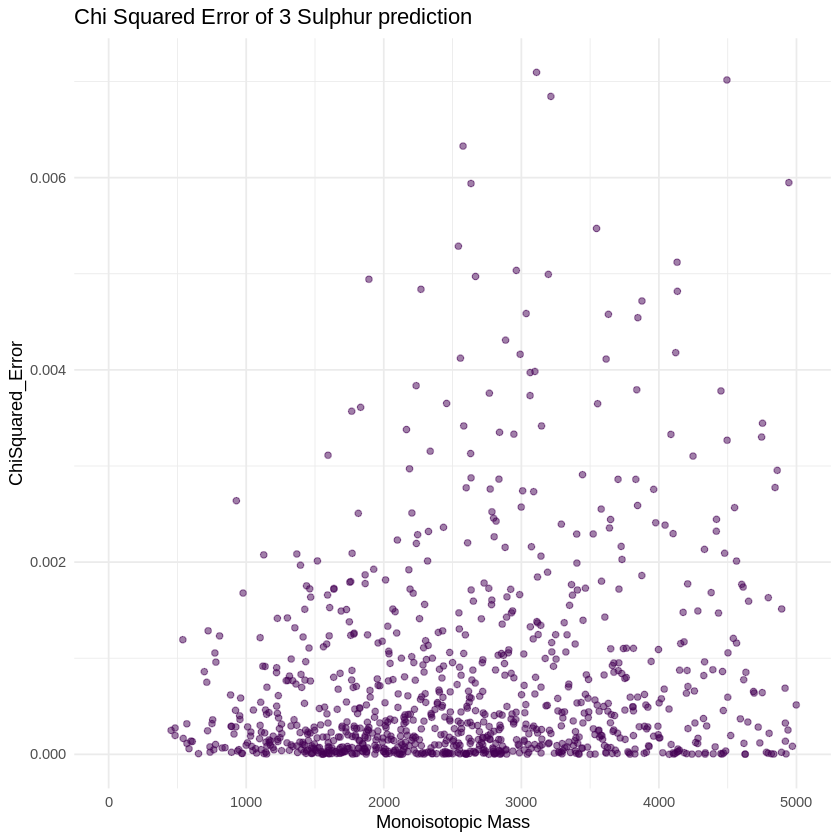

In [ ]:
# Scatter plot for the chi squared error between 3 Sulphur peptides and 3 Sulphur predictions
Human_peptides_Pointless_AllPredictions %>%
  filter(Sulphurs == 3 & Sulphurs_In_Prediction == 3) %>%
  select(`Monoisotopic Mass`, ChiSquared_Error) %>%
  ggplot(aes(x = `Monoisotopic Mass`, y = ChiSquared_Error, colour = "purple")) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  xlim(0, 5000)+
  ggtitle("Chi Squared Error of 3 Sulphur prediction")+
  scale_colour_viridis(discrete = TRUE) +
  theme(legend.position="none")

The errors are lower by a very large factor! In fact, compared to the 0 sulphur model, the error is even lower, meaning that model accuracy is quite high.

For reference, we can also show a plot with all correct sulphur predictions using the algorithm.

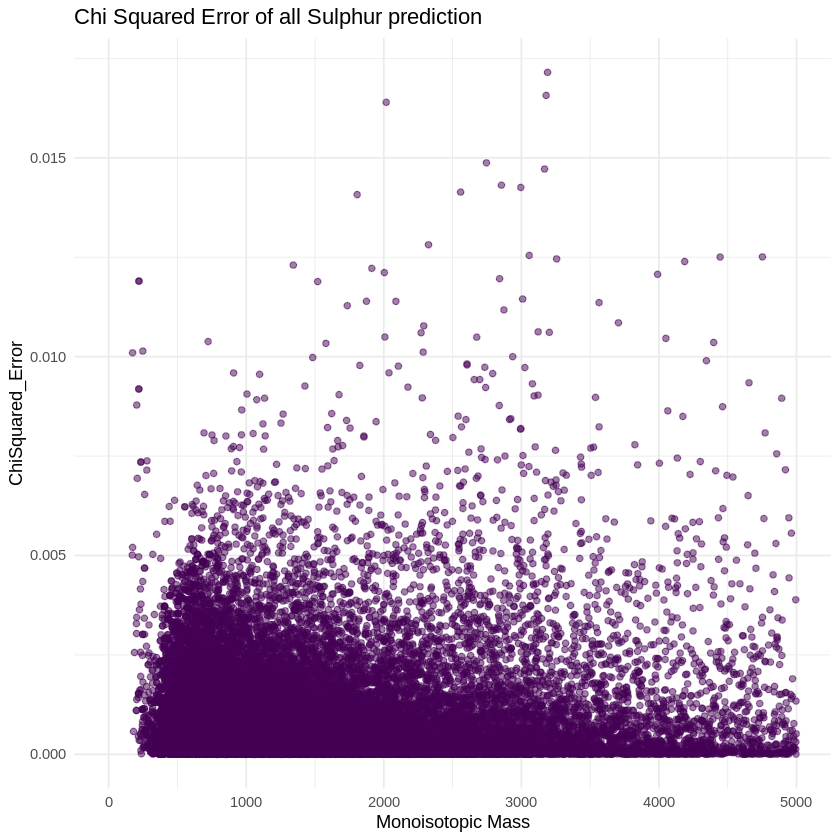

In [ ]:
# Scatter plot for the chi squared error between all correct predictions
Human_peptides_Pointless_AllPredictions %>%
  filter(Sulphurs == Sulphurs_In_Prediction) %>%
  select(`Monoisotopic Mass`, ChiSquared_Error) %>%
  ggplot(aes(x = `Monoisotopic Mass`, y = ChiSquared_Error, colour = "purple")) +
  geom_point(alpha = 0.5) +
  theme_minimal() +
  xlim(0, 5000)+
  ggtitle("Chi Squared Error of all Sulphur prediction")+
  scale_colour_viridis(discrete = TRUE) +
  theme(legend.position="none")

A decreasing error trend with increasing monoisotopic mass is also visible here. Due to the nature of the Chi-Squared error calculation, where the reference peak is also positioned in the denominator, small mistakes at very low values (for example, between the 6th probability peaks) will have a large impact on the total error.

It appears we need sulphur in our models, can we also use these models for classification of peptides without information on the sulphur contents? Instead, we will just use the monoisotopic mass.

To achieve this, we will take all peptides in our created dataframe and predict the 6 peaks as we did before. These values are already present in the dataset. Then, we group by every peptide and select the lowest error out of the six sulphur predictions.

In [ ]:
Human_peptides_Pointless_AllPredictions %>%
  filter(Sulphurs < 6) %>%
  group_by(Peptides) %>%
  slice_min(ChiSquared_Error)-> Human_peptides_Pointless_MinError

Human_peptides_Pointless_MinError %>%
  mutate(Correct_Prediction = Sulphurs == Sulphurs_In_Prediction) -> Human_peptides_Pointless_MinError

summary(Human_peptides_Pointless_MinError$Correct_Prediction)

   Mode   FALSE    TRUE 
logical    2271   36351 

So, based on only the error, we can see that a large amount of peptides already have the correct sulphur classification. In total, 94% of peptides are classified correctly, only based on the isotope distribution based on the monoisotopic mass.

In [ ]:
sum(Human_peptides_Pointless_MinError$Correct_Prediction)/(nrow(Human_peptides_Pointless_MinError))

[1] 0.9411993

We can now make a confusion matrix which compares all classes and look at the incorrect predictions.

In [ ]:
six_class_cm <- confusionMatrix(
  as.factor(Human_peptides_Pointless_MinError$Sulphurs_In_Prediction),
  as.factor(Human_peptides_Pointless_MinError$Sulphurs)
)
six_class_cm[["table"]]

          Reference
Prediction     0     1     2     3     4     5
         0 23631   337    10     0     0     0
         1   426  9142   216     4     1     0
         2    17   497  2626   106     4     0
         3     3    36   286   677    52     1
         4     0     3    28   134   182    22
         5     0     0     3    23    62    93

This confusion matrix also allows us to look at the specific classification between the prediction and the reference. As you can see, the main wrongly classified groups have a "lag" of one, i.e. there is one sulphur of difference. At higher sulphur content, the model performs a bit worse.

However, we disregarded noise here, as both BRAIN and Pointless4Peptides only generate theoretical distributions.
Let's use some noise by creating a "real world" example, sampling from a multinomial distribution based on the Brain isotope predictions.

Now, as with the BRAIN workshop, we select a peptide from which we will sample the probability distribution.
In this case, we would like a peptide that has 6 visible peaks, and has a few sulphurs.

Therefore, we select the peptide "LFEASDPYQVHVCNLCGIMAIANTR", which has:
*   A monoisotopic mass of 2764.3135 Daltons
*   Carbons: 120
*   Hydrogens: 189
*   Oxygens: 36
*   Nitrogens: 33
*   Sulphurs: 3

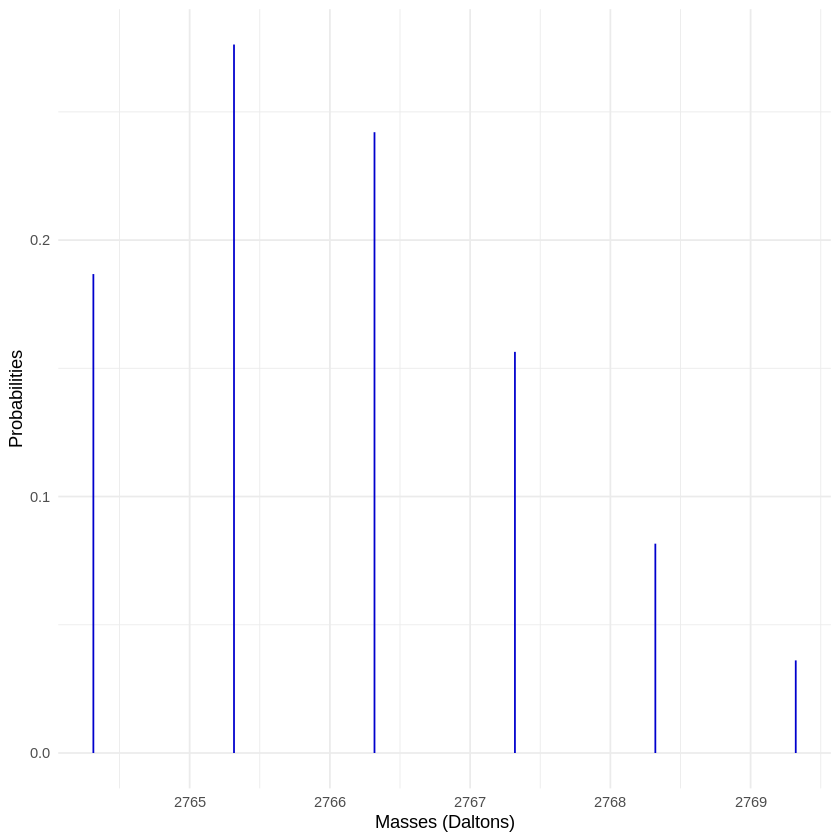

In [ ]:
Human_peptides_Pointless_AllPredictions %>%
  filter(Peptides == "LFEASDPYQVHVCNLCGIMAIANTR") %>%
  select(10:34)-> Peptide_to_sample

peptide_BRAIN_masses <- as.vector(as.matrix(Peptide_to_sample[1,1:6]))
peptide_BRAIN_intensities <- as.vector(as.matrix(Peptide_to_sample[1,7:12]))
peptide_BRAIN_restPeak <- 1-sum(peptide_BRAIN_intensities)

peptide_Pointless_intensities <- as.vector(as.matrix(Peptide_to_sample[1,20:23]))

peptide_DF <- data.frame(Masses = peptide_BRAIN_masses, Intensities = peptide_BRAIN_intensities)
peptide_DF %>%
  ggplot(aes(x = Masses, y = Intensities)) +
  geom_segment(aes(x=Masses, xend=Masses, y=0, yend=Intensities), colour = "mediumblue") +
  theme_minimal() +
  xlab("Masses (Daltons)") +
  ylab("Probabilities")

From this distribution, we will sample multinomially. To make sure the probabilities add up to 1, a "rest" peak is calculated, also called the "closure term".

Sampling is performed 50 times with a distribution with 100, 1000, 10000, 100000 ions and an error is calculated for each sample. Then, a boxplot of these errors is created to look at the effect of noise and sampling amount.

In [ ]:
Human_peptides_Pointless_AllPredictions %>%
  filter(Peptides == "LFEASDPYQVHVCNLCGIMAIANTR") %>%
  select(10:34)-> Peptide_to_sample

samples_100x = t(rmultinom(50, 100, c(peptide_BRAIN_intensities,peptide_BRAIN_restPeak)))
samples_1000x = t(rmultinom(50, 1000, c(peptide_BRAIN_intensities,peptide_BRAIN_restPeak)))
samples_10000x = t(rmultinom(50, 10000, c(peptide_BRAIN_intensities,peptide_BRAIN_restPeak)))
samples_100000x = t(rmultinom(50, 100000, c(peptide_BRAIN_intensities,peptide_BRAIN_restPeak)))

sum(peptide_BRAIN_intensities[1:4])

[1] 0.8614789

In real mass spectrometry experiments, we will not know the total ion count. However, we need to transform the count data we have now into probabilities. How do we do that?

Although we do not know the ion count, we know the percentage of the first few peaks thanks to the theoretical distribution. In this case, the first four peaks will account for ~86% of the total ion count. From this assumption, we can recalibrate the intensities into probabilities.

In [ ]:
probs_100x = samples_100x[,1:4]/(rowSums(samples_100x[,1:4])/sum(peptide_BRAIN_intensities[1:4]))
probs_1000x = samples_1000x[,1:4]/(rowSums(samples_1000x[,1:4])/sum(peptide_BRAIN_intensities[1:4]))
probs_10000x = samples_10000x[,1:4]/(rowSums(samples_10000x[,1:4])/sum(peptide_BRAIN_intensities[1:4]))
probs_100000x = samples_100000x[,1:4]/(rowSums(samples_100000x[,1:4])/sum(peptide_BRAIN_intensities[1:4]))

In [ ]:
samples_chisq_df = as.data.frame(matrix(nrow = 50, ncol = 0))

peptide_Pointless_intensities_df <- do.call("rbind", replicate(
  50, as.data.frame(t(peptide_Pointless_intensities)), simplify = FALSE))

temp_df = ((probs_100x - peptide_Pointless_intensities_df)^2)/peptide_Pointless_intensities_df
samples_chisq_df["Error_100x"] = rowSums(temp_df)

temp_df = ((probs_1000x - peptide_Pointless_intensities_df)^2)/peptide_Pointless_intensities_df
samples_chisq_df["Error_1000x"] = rowSums(temp_df)

temp_df = ((probs_10000x - peptide_Pointless_intensities_df)^2)/peptide_Pointless_intensities_df
samples_chisq_df["Error_10000x"] = rowSums(temp_df)

temp_df = ((probs_100000x - peptide_Pointless_intensities_df)^2)/peptide_Pointless_intensities_df
samples_chisq_df["Error_100000x"] = rowSums(temp_df)

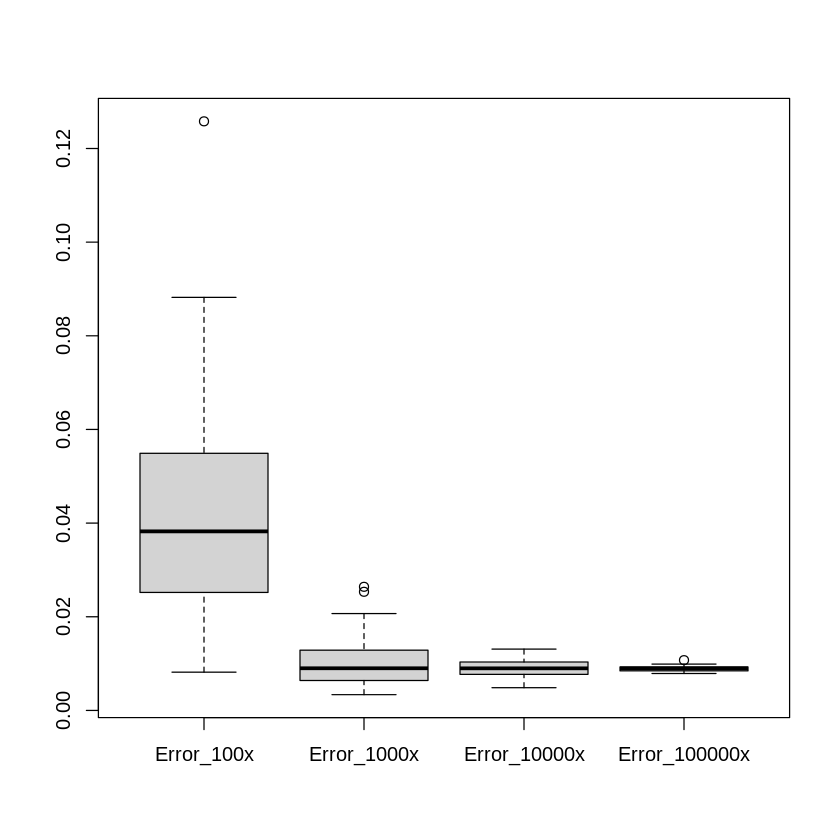

In [ ]:
boxplot(x = as.list(samples_chisq_df))

# MIND

## Workshop

In this part of the workshop we will explore the MIND method for predicting monoisotopic mass of a protein based on the mass of the highest peak in the observed isotope distribution. To demonstrate how to use MIND, the dataset from the BRAIN session will be reused.

A more detailed description of the algorithm can be found in the corresponding article.

Lermyte, F., Dittwald, P., Claesen, J., Baggerman, G., Sobott, F., O’Connor, P. B., Laukens, K., Hooyberghs, J., Gambin, A., & Valkenborg, D. (2019). MIND: a Double-Linear model to accurately determine monoisotopic precursor mass in High-Resolution Top-Down proteomics. Analytical Chemistry, 91(15), 10310–10319. https://doi.org/10.1021/acs.analchem.9b02682


Nomenclature: the mass of the most-abundant (i.e., highest) peak will be referred to as "most-abundant mass".

The chunk below reads in the human proteome dataset and draws a random sample of 1000 protein sequences.

In [ ]:
set.seed(2024)

Human_proteome <- phylotools::read.fasta("https://raw.githubusercontent.com/VilenneFrederique/EuBIC2024WS/main/uniprotkb_Human_AND_model_organism_9606_2023_12_01.fasta")
Human_proteome <- Human_proteome$seq.text
# Find indices of elements containing the letter 'U'
indices_to_remove <- grep("U", Human_proteome)

# Remove elements containing 'U'
Human_proteome <- Human_proteome[-indices_to_remove]

protein_sequence_length <- str_length(Human_proteome)

# MIND has been trained on proteins with the highest peak within ~8 000 - 60 000 Da. But we don't have yet any mass information, just amino acid sequence, so below is a heuristic on the sequence length.

Human_proteome_subset <- Human_proteome[protein_sequence_length >= 70 & protein_sequence_length < 500]

# We will analyse ~ 1000 proteins
Human_proteome_sampled <- sample(Human_proteome_subset, size = 1000, replace = FALSE)

We wrote a function to obtain protein atomic compositions that are needed for calculating peak masses and intensities with BRAIN.

In [ ]:
get_atomic_compositions <- function(molecule_sequences, nr_peaks){

  DF <- data.frame(Molecule = molecule_sequences)
  DF["AAComp"] <- NA
  DF["Monoisotopic Mass"] <- NA
  DF["Average Mass"] <- NA
  DF["Carbons"] <- NA
  DF["Hydrogens"] <- NA
  DF["Oxygens"] <- NA
  DF["Nitrogens"] <- NA
  DF["Sulphurs"] <- NA

  for (i in 1:nr_peaks){
    DF[paste0("BRAINMassPeak", i)] <- NA
    DF[paste0("BRAINRelativeIsotopePeak", i, "Intensity")] <- NA
  }

  for(index in 1:nrow(DF)){
    # Extract information from dataframe required
    Molecule <- DF[[index, "Molecule"]]
    # Firstly, we calculate the atomic composition of a peptide sequence and store the results into our dataframe
    AAComp <- getAtomsFromSeq(Molecule)
    DF[index, "Carbons"] <- AAComp[["C"]]
    DF[index, "Hydrogens"] <- AAComp[["H"]]
    DF[index, "Oxygens"] <- AAComp[["O"]]
    DF[index, "Nitrogens"] <- AAComp[["N"]]
    DF[index, "Sulphurs"] <- AAComp[["S"]]
    DF[index, "AAComp"] <- paste0("C", AAComp[["C"]], "H", AAComp[["H"]], "O", AAComp[["O"]], "N", AAComp[["N"]], "S", AAComp[["S"]])
    # Using the amino composition, we can calculate the monoisotopic and average mass
    DF[index, "Monoisotopic Mass"] <- calculateMonoisotopicMass(AAComp)
    DF[index, "Average Mass"] <- calculateAverageMass(AAComp)
    # Lastly, we will calculate the probabilities of aggregated isotopic variants
    BRAINResults <- useBRAIN(aC = AAComp, stopOption="nrPeaks", nrPeaks = nr_peaks)

    for (j in 1:nr_peaks){
      DF[index, paste0("BRAINMassPeak", j)] <- BRAINResults[["masses"]][j]
      DF[index, paste0("BRAINRelativeIsotopePeak", j, "Intensity")] <- BRAINResults[["isoDistr"]][j]
    }
  }
  return(DF)
}

We then apply the function to the sampled proteins. Since some of the proteins have large molecular weight, and therefore, many isotopes, we request 50 peaks in the output isotope distributions. Note: computations will take a couple of seconds.

In [ ]:
Human_proteome_DF <- get_atomic_compositions(molecule_sequences = Human_proteome_sampled, nr_peaks = 50)

For each protein, we need to determine its most-abundant mass.

In [ ]:
mass_col_index <- str_detect(colnames(Human_proteome_DF), "BRAINMass")
intensity_col_index <- str_detect(colnames(Human_proteome_DF), "BRAINRelativeIsotope")

# mab_mass = most-abundant mass
mab_mass <- numeric(nrow(Human_proteome_DF))

for (i in 1:length(mab_mass)) {
  x <- Human_proteome_DF[i,]
  max_intensity <- max(x[intensity_col_index])
  max_intensity_ind <- min(which(x[intensity_col_index] == max_intensity))
  mab_mass[i] <- as.numeric(x[which(mass_col_index)][max_intensity_ind])
}

Additionally, proteins with the most-abundant mass falling outside the mass range used for training MIND are filtered out.

In [ ]:
MIND_mass_range_index <- mab_mass >= 8005.1802 & mab_mass <= 60036.47
mab_mass <- mab_mass[mab_mass >= 8005.1802 & mab_mass <= 60036.47]
Human_proteome_DF <- Human_proteome_DF[MIND_mass_range_index,]

In [ ]:
nrow(Human_proteome_DF)

[1] 999

A quick look on the distribution of the most-abundant masses of the sampled proteins.

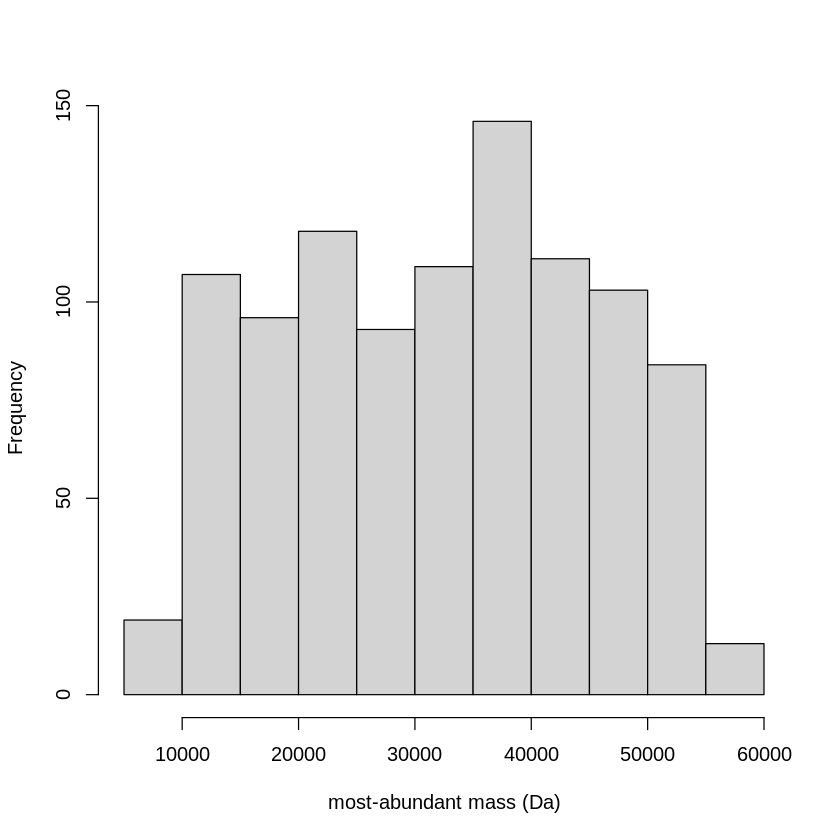

In [ ]:
hist(mab_mass, main = "", xlab = "most-abundant mass (Da)")

We see that the distribution is largely uniform, meaning that we will be able to test MIND on its entire domain. MIND has been implemented as an online [Shiny app](https://valkenborg-lab.shinyapps.io/mind/.) that can be used without local R installation.

Let's now save the mass values into a csv file. **CAUTION**: there should be only one column, without a header! Otherwise an error will be returned by the Shiny app. Moreover, the column should store numeric values within the MIND mass domain, i.e., **[8005.18, 60036.47] Da**. In case you don't want to save the csv locally or may not be able to find it, the GitHub contains a copy of the CSV.

In [ ]:
write.table(mab_mass, "mab_mass.csv", row.names = FALSE, col.names = FALSE)

The time has come to present the recipe for generating monoisotopic mass predictions with MIND.

1. Open a web browser and go to https://valkenborg-lab.shinyapps.io/mind/.
2. Select the "Multiple masses" button.
3. Click on "Browse" and upload the csv file with input masses.
4. We're all set to execute MIND by hitting the "Calculate" button.
5. Press "Download Table" and save somewhere on your machine the MIND output CSV file with monoisotopic mass predictions and off-by-one probabilities.

Let's read in the output CSV file stored on the GitHub page.

In [ ]:
MIND_output <- read.csv("https://raw.githubusercontent.com/VilenneFrederique/EuBIC2024WS/main/Monoisotopic_Mass.csv")
colnames(MIND_output) <- c("mab_mass", "monoisotopic_mass_MIND", "probability_minus1Da", "probability_0Da", "probability_plus1Da")
head(MIND_output)

,mab_mass,monoisotopic_mass_MIND,probability_minus1Da,probability_0Da,probability_plus1Da
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,25131.66,25116.62,0.14826021,0.7836611,0.05900151
2,46404.17,46376.09,0.29444444,0.4694444,0.19722222
3,30479.80,30461.75,0.24375000,0.5250000,0.20833333
4,18143.88,18132.85,0.02105263,0.7789474,0.19473684
5,47685.94,47656.87,0.23611111,0.6444444,0.08888889
6,36879.72,36857.67,0.23798077,0.4855769,0.18990385


The three probability columns above correspond to the integer part of model 1 residuals, explained in detail in the MIND article and in the theoretical introduction to MIND given earlier during the winter school.

Below is the visualisation of the **prediction error**, defined as the **difference between MIND-predicted and BRAIN-calculated** monoisotopic mass value, against the most-abundant mass.

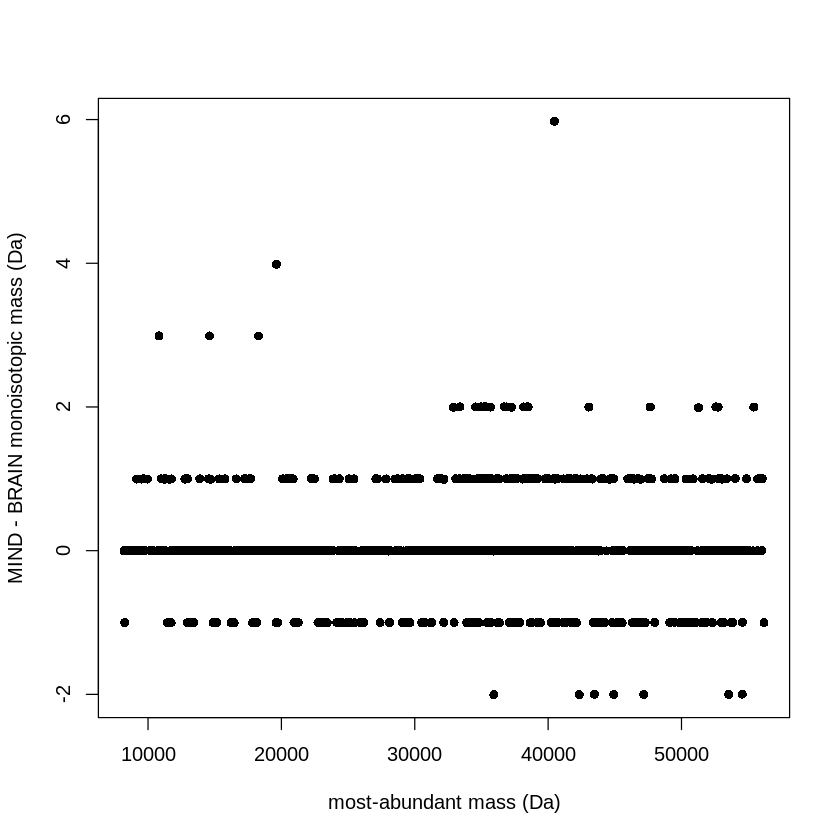

In [ ]:
MIND_minus_BRAIN_da <- MIND_output$monoisotopic_mass_MIND - Human_proteome_DF$`Monoisotopic Mass`

MIND_minus_BRAIN_ppm <- MIND_minus_BRAIN_da/Human_proteome_DF$`Monoisotopic Mass` * 10^6

plot(MIND_minus_BRAIN_da ~ mab_mass, pch = 16,
     xlab = "most-abundant mass (Da)",
     ylab = "MIND - BRAIN monoisotopic mass (Da)")

We've just seen that the prediction errors form approximately horizontal lines, so we can categorise these errors and summarise their proportions.

In [ ]:
# compute off-by-one error proportion table
off_by_one_labels <- c("<=-2 Da", "(-2 Da, -1 Da)", "-1 Da", "(-1 Da, 0 Da)", "0 Da", "(0 Da, +1 Da)", "+1 Da", "(+1 Da, +2 Da)",">= +2 Da")

off_by_one_labels <- factor(x = off_by_one_labels, levels = off_by_one_labels, ordered = TRUE)

off_by_one_index <- findInterval(MIND_minus_BRAIN_da, vec = c(-2.2, -1.8, -1.2, -0.8, -0.2, 0.2, 0.8, 1.2, 1.8, 2.2))

MIND_minus_BRAIN_da_label <- off_by_one_labels[off_by_one_index]

tab_counts <- table(MIND_minus_BRAIN_da_label)

tab_percentage <- 100*tab_counts/sum(tab_counts)

tmp <- data.frame(Category = names(tab_percentage), Percentage = as.numeric(tab_percentage))

View(tmp)

Category,Percentage
<chr>,<dbl>
<=-2 Da,0.7042254
"(-2 Da, -1 Da)",0.0000000
-1 Da,16.3983903
"(-1 Da, 0 Da)",0.0000000
0 Da,62.0724346
"(0 Da, +1 Da)",0.0000000
+1 Da,18.4104628
"(+1 Da, +2 Da)",0.0000000
>= +2 Da,2.4144869


The results presented in the table are in line with outcomes included in the paper: in around 60% of the sampled proteins, MIND predictions end up with the "0 Da" error label. This label implies a negligible prediction error, as confirmed in two close-up graphs below (only proteins with the "0 Da" label are shown; ppm scale).

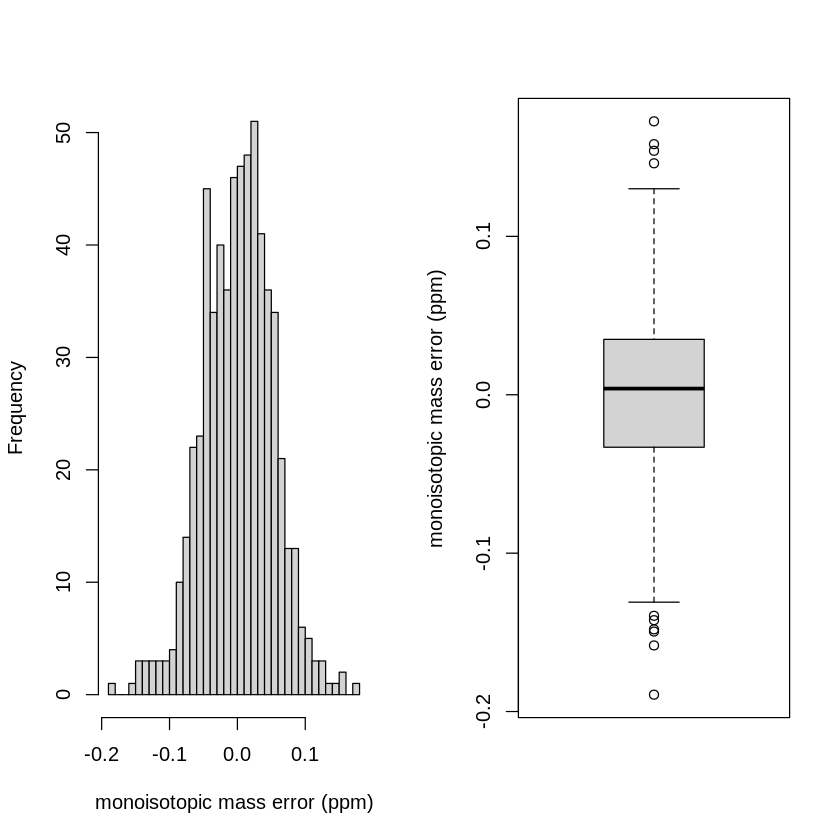

In [ ]:
par(mfrow=c(1,2))
  hist(MIND_minus_BRAIN_ppm[MIND_minus_BRAIN_da_label == "0 Da"], breaks = 50, xlab = "monoisotopic mass error (ppm)", main = "")
  boxplot(MIND_minus_BRAIN_ppm[MIND_minus_BRAIN_da_label == "0 Da"], ylab = "monoisotopic mass error (ppm)")
par(mfrow = c(1,1))

A mistake in choosing the highest peak leads to an invalid monoisotopic mass prediction with MIND. This problem is frequently seen when analysing broad isotope distributions of large molecules. In such cases, several peaks have theoretical intensities only a few percent below that of the most-abundant peak, which increases the chance of selecting an incorrect peak. Poor ion statistics also contribute to this kind of error.

For these reasons, Lermyte et al. have presented a way to diminish this issue in the *Further Refinement: Correction for Poor Ion Statistics* section of the MIND article. To illustrate how the refinement works, we will use one protein with molecular weight around 20 kDa.

In [ ]:
one_protein_index <- str_detect(Human_proteome_DF$Molecule, "MATQQVDSRRQVAAEQVAAQLLERRRGSHCDDEKQTLLALLILV")

one_protein <- Human_proteome_DF[one_protein_index, ]

true_mam <- mab_mass[one_protein_index]

true_ma_peak_number <- which(Human_proteome_DF[one_protein_index, mass_col_index] == true_mam)

Some information about the selected protein:

In [ ]:
one_protein %>% select(Molecule:Sulphurs)

# true peak number and mass of the most-abundant isotope variant
c(true_ma_peak_number, true_mam)


,Molecule,AAComp,Monoisotopic Mass,Average Mass,Carbons,Hydrogens,Oxygens,Nitrogens,Sulphurs
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
355,MATQQVDSRRQVAAEQVAAQLLERRRGSHCDDEKQTLLALLILVLYLSTEIWGSSWEVSERIRECNYYQNLAVPQGLEYQTNEPSEEPIKTIRNWLKEKLHVFSEKLEEEVQQLEQLAWDLELWLDALLGEPHQEEHCSTYKSHLWEWAWALGREHKGGEGLLEISLSGAEL,C891H1381O275N243S4,20013.04,20025.27,891,1381,275,243,4


[1]    13.00 20025.08

So the 13th peak is the most-abundant isotopic variant at 20025 Da.

Next, to mimic the variability on peak intensities that is caused by ion sampling occurring inside the mass spectrometer, we will exploit a multinomial distribution in which the probabilities are set to BRAIN-calculated intensities. Total ion count is set to a relatively small value of 10000. We then draw 100 samples from the multinomial distribution.

In [ ]:
multinom_samples <- rmultinom(n = 100, size = 10000, prob = one_protein[intensity_col_index])
one_protein_masses <- as.numeric(one_protein[, mass_col_index])

Below the most-abundant peak is designated for all samples by simply looking at the peak intensities.

In [ ]:
samples_mam_peak_number <- apply(multinom_samples, 2, function(x) min(which(x == max(x))))

Let's look at the visualisation of three random samples.

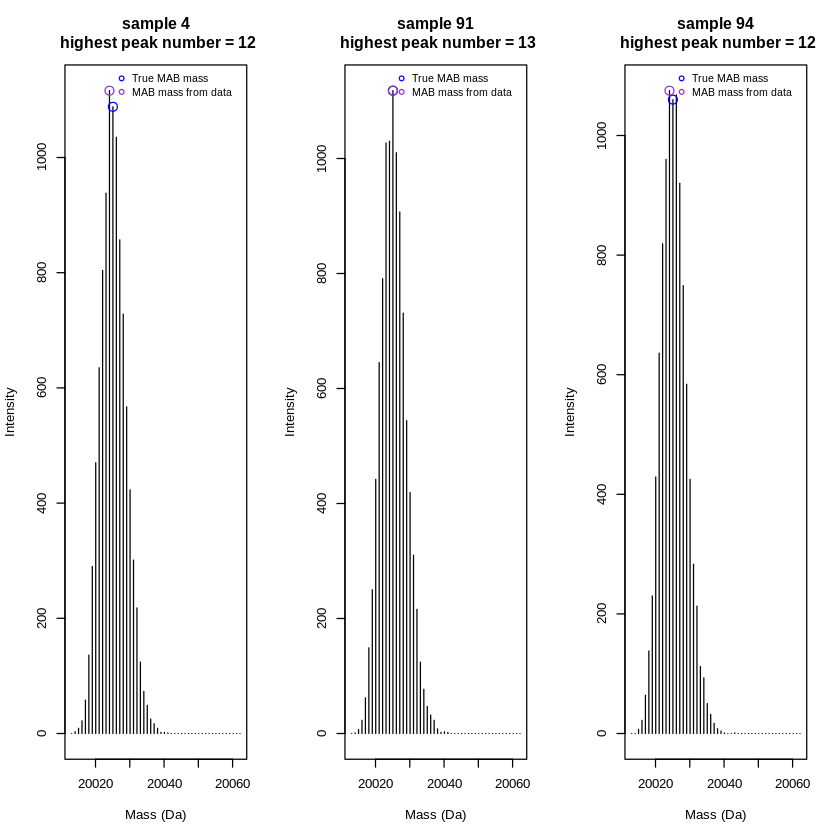

In [ ]:
par(mfrow = c(1,3))
iter <- sort(sample(1:100, 3))

for (i in iter){
  plot(multinom_samples[,i] ~ I(as.numeric(one_protein[mass_col_index])), type = 'h', xlab = "Mass (Da)", ylab = "Intensity", main = paste0("sample ", i, "\n highest peak number = ", samples_mam_peak_number[i]))

  points(x = c(true_mam, one_protein_masses[samples_mam_peak_number[i]]),
         y = c(multinom_samples[c(true_ma_peak_number, samples_mam_peak_number[i]), i]),
         col = c("blue", "darkorchid3"), cex = 1.5)

  legend("topright", legend = c("True MAB mass", "MAB mass from data"), col = c("blue", "darkorchid3"), bty = 'n', pch=1, cex = 0.8)
}
par(mfrow = c(1,1))

Indeed, we can clearly observe variation in the peak heights and the resulting errors in most-abundant peak selection.


In [ ]:
mab_peak_number_error <- unname(samples_mam_peak_number) - true_ma_peak_number

(tab_error1 <- table(mab_peak_number_error))

mab_peak_number_error
-1  0  1 
47 48  5 

In a large number of cases, the index of the highest peak in the sampled peak patterns is larger by plus one compared to the true index number 13. The opposite case, i.e. the selected peak index being lower by one, is much less frequent. This can be explained by looking at the probabilities of the peaks number 12, 13, and 14: 9.78\%, 10.38\%, 10.28\%, respectively. So the probability value of peak 14 is closer to the most-abundant one than peak 13.

The workflow to pinpoint the "true" most-abundant mass involves iteratively calculating the difference between the intensity-weighted average mass and the highest peak mass. Across around 78 000 protein sequences found in the MIND training dataset, such a difference consistently range from 0.1 to 1.2 Da.

Let's check what is the range of the difference among the **initially sampled 1000 proteins**.

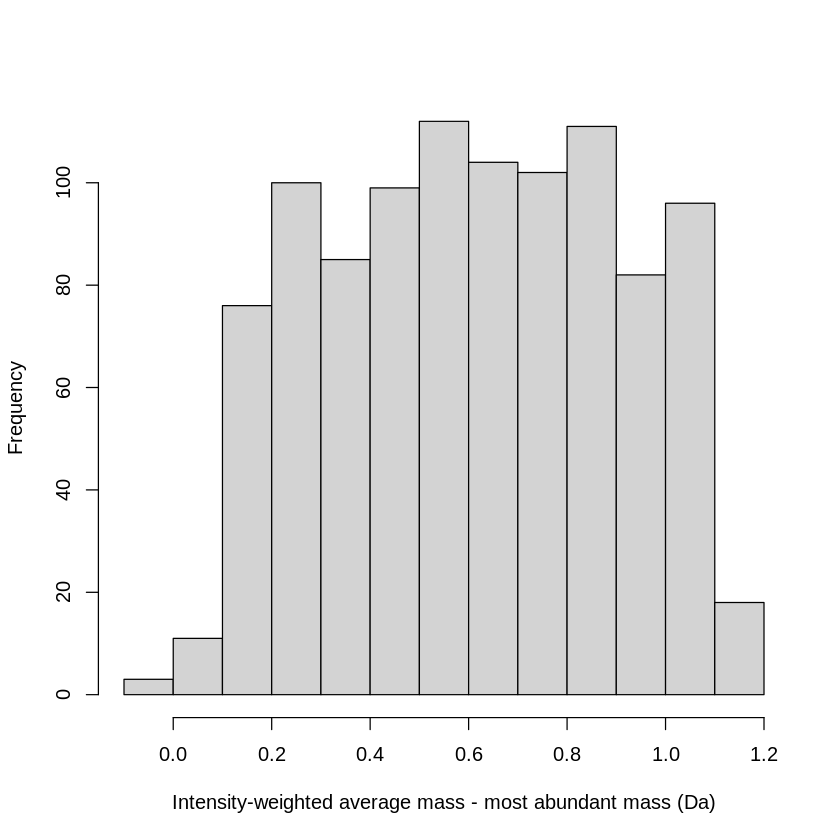

In [ ]:
q_tmp <- Human_proteome_DF[, intensity_col_index]
m_tmp <- Human_proteome_DF[, mass_col_index]

# calculate average mass minus most abundant
row_q_sum <- apply(q_tmp, 1, sum, na.rm = TRUE)
q_tmp <- apply(q_tmp, 2, function(x) x / row_q_sum)
wgt_avg_mass <- apply(q_tmp * m_tmp, 1 , sum)
the_difference <- wgt_avg_mass - mab_mass
hist(the_difference, main = " ", xlab = "Intensity-weighted average mass - most abundant mass (Da)")


The difference behave similarly as in the original publication, so we will be using theerein proposed thresholds.

Therefore, when the value of the difference exceeds 1.2 Da, it means incorrect selection of the signal to the left of the authentic most-abundant isotope peak. In such cases, the subsequent peak in the series should be employed as input for the MIND algorithm.

Conversely, a value of the difference below 0 indicates that the chosen peak is too heavy, necessitating the selection of the preceding peak in the isotope distribution.
This procedure (also visualised on the GitHub as "mam_heuristic.PNG") is repeated until the difference falls again inside the [0.1, 1.2] Da interval.

We will be applying the heuristic to the simulated isotope distributions of the selected protein.

In [ ]:
# compute intensity-weighted average mass (without using atomic composition)
multinom_samples_t <- t(multinom_samples)
q_tmp <- multinom_samples_t
m_tmp <- as.numeric(one_protein[, mass_col_index])
row_q_sum <- apply(q_tmp, 1, sum, na.rm = TRUE) # the row sums are 10 000, but this way we avoid hardcoding
q_tmp <- apply(q_tmp, 2, function(x) x / row_q_sum)
wgt_avg_mass <- apply(q_tmp , 1 , function(x) sum(x * m_tmp))

mam_peak_initial <- m_tmp[samples_mam_peak_number]
mam_peak_corrected <- numeric(length(mam_peak_initial))
the_difference <- as.numeric(wgt_avg_mass - mam_peak_initial)

threshold <- c(0.1, 1.2)

for (i in 1:length(mam_peak_initial)) {
  best_mode_mass <- mam_peak_initial[i]
  delta <- the_difference[i]
  peak_ind <- samples_mam_peak_number[i]
  n_iter <- 0

  direction <-
    ifelse(
      between(delta, threshold[1], threshold[2]),
      "middle",
      ifelse(delta > threshold[2], "upper", "lower")
    )

  while (delta < threshold[1] | delta > threshold[2]) {
    peak_ind_prev <- peak_ind

    if ((delta > threshold[2])  & direction == "upper") {
      peak_ind <- peak_ind + 1
    } else if ((delta < threshold[1]) & direction == "lower") {
      peak_ind <- peak_ind - 1
    }

    n_iter <- n_iter + 1

    if (peak_ind == peak_ind_prev) {
      mam_peak_corrected[i] <- m_tmp[peak_ind]
      break()

    } else {
      best_mode_mass <- m_tmp[peak_ind]
      delta <- wgt_avg_mass[i] - best_mode_mass
    }
  }
  mam_peak_corrected[i] <- m_tmp[peak_ind]
}

In [ ]:
samples_mam_peak_number_corrected <- unlist(lapply(mam_peak_corrected, function(x) which(x == m_tmp)))

mab_peak_number_error2 <- samples_mam_peak_number_corrected - true_ma_peak_number

(tab_error2 <- table(mab_peak_number_error2))

mab_peak_number_error2
-1  0 
26 74 

This means that  all the initially incorrectly chosen peaks (`r sum(tab_error1[names(tab_error1) != "0"])` in total) have been fixed with this procedure!

Finally, let's revisit the three earlier visualised simulated isotope distributions.

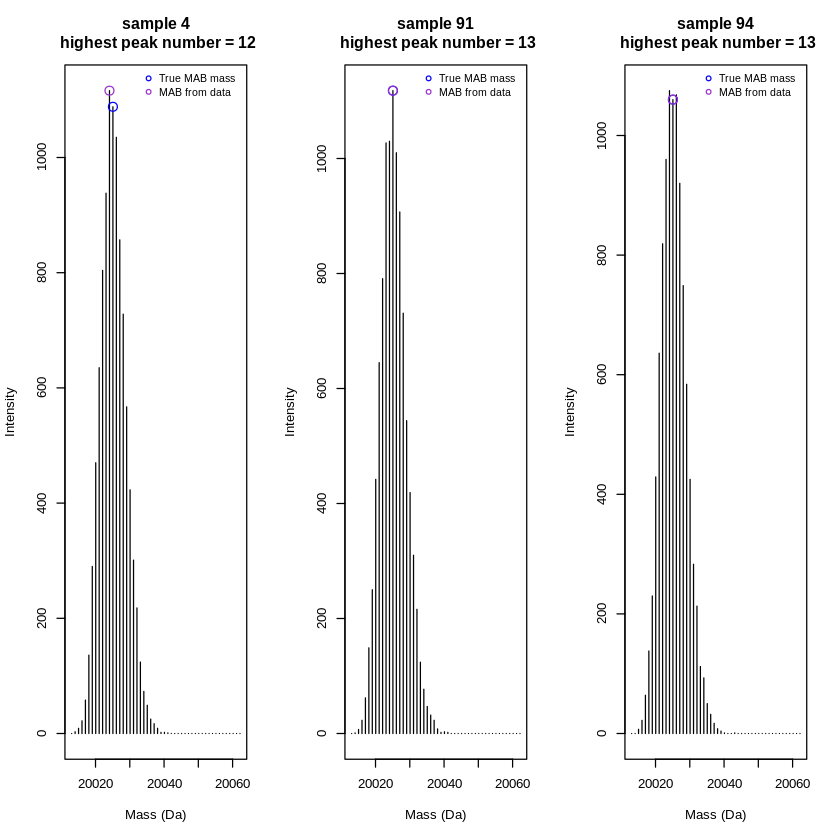

In [ ]:
par(mfrow = c(1,3))
for (i in iter){

  plot(multinom_samples[,i] ~ I(as.numeric(one_protein[mass_col_index])), type = 'h', xlab = "Mass (Da)", ylab = "Intensity", main = paste0("sample ", i, "\n highest peak number = ", samples_mam_peak_number_corrected[i]))

  points(x = c(true_mam, one_protein_masses[samples_mam_peak_number_corrected[i]]),
         y = c(multinom_samples[c(true_ma_peak_number, samples_mam_peak_number_corrected[i]), i]),
         col = c("blue", "darkorchid3"), cex = 1.5)

  legend("topright", legend = c("True MAB mass", "MAB from data"), col = c("blue", "darkorchid3"), bty = 'n', pch = 1, cex = 0.8)
}
par(mfrow = c(1,1))

#QCQuan

## Workshop

To demonstrate QCQuan, we will work with a real-life mass spectrometry experiment. QCQuan itself may be accessed through the following link:

https://qcquan.net/

We will use experimental data from an experiment performed by Ivanov et al. *. To shortly elaborate on the experiment. They performed a labelled LC-MS/MS experiment on several samples. We will work specifically with two samples from a Glioblastoma Multiforme cell culture. One of these samples was treated with recombinant interferon alpha-2b. They added TMT-labels to the samples for quantification. The MS/MS-based analysis was performed using a Q-Exactive HF mass spectrometer with sample prefractionation.

MS/MS data analyses using Proteome Discover (version 2.5) with SEQUEST HT as a search engine. Parameters were set as follows: Up to two missed cleavage sites were allowed, carbamidomethylation of cysteine as fixed modification, oxidation of methionine as a variable modification, 10ppm and 0.05 Da precursor and fragment mass accuracies.

In general, QCQuan only requires two things:

1.   Design of Experiment File (DoE): As the name mentions, you are required to provide information on the experiment which will be analysed.
2.   A ProteomeDiscover file with peptide spectral matches. However, one side-note here is that QCQuan was designed for ProteomeDiscover version 2.1.

In order to save a bit if time, we went ahead and created a DoE-file for everyone, available on the GitHub page. It can be recreated by manually by using the "DoE Creator", available on the top-left of the website. In general, it creates a tab-separated file with at least 3 columns:

1.   Name of the result-file belonging to an MS-run.
2.   Columns belonging to each condition present in the MS-runs. In our case, we have two columns, one belonging with the TMT-labels for the interferon-treated samples and the other one belonging to the untreated sample. Do note, it is important that each of the labels mentioned here are also present in the ProteomeDiscover file with PSMs as separate columns with abundances.

As for the ProteomeDiscover file, we also took the liberty to prepare these files for you and post them on the GitHub page. They are also available on PRIDE through the identifier "PXD033355" by downloading the ProteomeDiscover results zip-folder.

https://www.ebi.ac.uk/pride/archive/projects/PXD033355

We manually edited the results file slightly because QCQuan is not yet fully-compatible with the newest version of ProteomeDiscover.

In general: QCQuan requires several columns to be present in the results-file. More information on this may be found in the support documentation of QCQuan (https://qcquan.net/docu#PSMfiles). Of course, not everyone here may be using ProteomeDiscover as a search engine but other popular algorithms such as Peaks, MaxQuant, MSFragger, ..., and may still be interested in using QCQuan for a differential expression analysis. This is still possible by creating a wrapper. More information about this can be found through: https://qcquan.net/docu#wrapper


However, for now, we will continue on working with our data. We would like you to join us on the web-application of QCQuan:

https://qcquan.net/

---

**Data reference:**

Ivanov, M. V., Bubis, J. A., Gorshkov, V., Tarasova, I. A., Levitsky, L. I., Solovyeva, E. M., Lipatova, A. V., Kjeldsen, F., & Gorshkov, M. V. (2022). DirectMS1QUANT: Ultrafast quantitative proteomics with MS/MS-Free Mass spectrometry. Analytical Chemistry, 94(38), 13068–13075. https://doi.org/10.1021/acs.analchem.2c02255





Below you can find a step-by-step guide to run QCQuan.


*   In order to run a new experiment using QCQuan, you can click "New QCQuan Job" in the top-right corner.
*   As a job name, you may chose anything, e.g. EuBICWS2024
*   Next up, you can upload the DoE-file and may proceed further by clicking "Create new job"
*   A new screen will open with the first option giving you the possibility to notify you if the job is completed by sending an e-mail.
*   Next up, you have to indicate if you used ProteomeDiscover or not. In our case, we did rely on ProteomeDiscover and used Sequest only as PSM algorithm. You can adjust accordingly. Do note, using the wrapper and the "Custom" option is entirely possible.
*   Select your reference condition such as the "Untreated" group for us.
*   By unfolding the "Advanced settings", we can choose to perform an analysis that includes shared peptides in the protein expression (Peptides present in more than 1 protein), show more differential proteins in the PDF and choose the output format. For now, let's just keep the factory settings.
*   Lastly, you may upload the PSM data and by unfolding the "Advanced settings", add a wrapper-file to each of the PSM data. In our case, this is not necessairy.

Great! That's all set and done! Submit the job and wait for the magic to happen. (~ 3 minutes)







Our results will be stored in a PDF and in a zipped folder. We will start out by going over the results of the PDF as they present everything in a summarised manner.

**PDF**


*   The first chapter is about the differential expression analysis with a a sole visualisation, a volcano plot of the differential expression of proteins. On the y-axis are the log10 p-values and on the x-axis log2 fold change.Whenever a protein has a significant p-value (<0.05) and fold change (>1), the dots are coloured red. Blue coloured dots only have a significant p-value and green coloured dots solely a significant fold change. As you may notice, several proteins were found significant. In the table below the volcano plot you can observe the top 10 most significant proteins according to the adjusted p-value, controlling the FDR through the Benjamini-Hochberg correction.  
*   A second chapter is dedicated to quality control of the MS-runs. In section 2.1, the experimental set-up of the DoE file is reiterated, which mostly serves to give us a nice overvieuw. Section 2.2 performs a principal component analysis. A PCA captures the direction of the highest variability in your dataset and calculates principal components. Usually, most information is captured in the first 2 principal components, as shown in this graph. The first and second PC capture 53\% of all information in the data. In section 2.3. Here we show a dendrogram of the clustering of the isobaric labels with the Euclidean distance as distance measure. Both plots serve as quality control tools. If the normalisation was succesful and there are sufficient differentially expressed proteins between samples, the samples should be grouped together per condition. If clustering per MS-run occurs, this could indicate problems in normalisation. Luckily, this is not really the case for us. A final part of chapter 2 shows miscellaneous section. A first and final visualisation shown is the MS1 calibration plot. This is a scatterplot of the relative PSM engine score and mass shift between theoretical and experimental mass in ppm. Each MS/MS run is coloured. What should be ideal here? Another optional plot is the MS1 Intensity histogram, which shows the amount of detected PSMs in function of their MS1 intensity. Ofcourse, QCQuan requires additional information of the MS1-layer in order to be able to include this.
Finally, section 2.3 concludes with summary statistics which can shortly go over.
*   The final chapter 3 concludes with a logging on the algorithm. In case of troubleshooting, this may hold valuable information to get rid of all your headaches!



Ofcourse, if we want to perform a complete analysis, we should look into the differentially expressed proteins. QCQuan gave us a list of differentially expressed proteins with p-values. But ofcourse, what do these proteins actually tell us?

In order to acquire more insight into the differentially expressed proteins, we will be performing a GO-analysis. Without going into too much depth, a GO-analysis will allow us to look into enriched genes. In our case, enriched genes of our INF-treated samples. To do so, we will look into the results-folder of QCQuan and open the ZIP file. Here, you may find a file named "Test_results_minimal.tsv". This file contains all necessary information on the proteins and their p-values.

We prepared a file on the GitHub page with in the GO analysis folder with the name "QCQuan_significant_proteins.xlsx". Here you can find all the proteins and their FDR-corrected p-values. Ofcourse, gene ontology works with genes, not proteins. We transformed the protein identifiers to ENTREZ GENE IDs using the Uniprot ID-mapping and stored the results into txt-files.

As for the GO-Analysis:

*   Go to DAVID (Database for Annotation, Visualization and Integrated Discovery)
https://david.ncifcrf.gov/
*   Click on "Shortcut to DAVID Tools" and select Functional Annotation.
*   You may upload the list of significant genes first. Make sure to select the correct identifier here (ENTREZ_GENE_ID) and click on Gene List. Next, you may submit the list.
*   You can upload the list with all genes too. However, this time instead of selecting a gene list, select a background list in order to properly normalise the data.
*   You may click "Clear all" and manually select BP, CC and MF under the header of Gene_Ontology and click on "Functional Annotation Clustering" at the bottom.

You will receive a complete GO-analysis of the study and results acquired through QCQuan. We will leave the interpretation of these results to the biologists. Our work here is done!







As a final note of this workshop, we hope you enjoyed following the workshop and thank you for your attendance!